# Topic modeling of Svevo Letter Corpus

# Imports

In [1]:
# General
import string
import numpy as np
import pandas as pd
import warnings

# Gensim
import gensim
from gensim import corpora, models
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, KeyedVectors
from gensim.models.wrappers import LdaMallet
from gensim.test.utils import datapath

# Lemmatization
import spacy

# Silhouette index and shuffle method
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.utils import shuffle

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

# Global variables and settings

In [17]:
# Ignore warnings in libraries
warnings.filterwarnings("ignore")

# Import Italo Svevo corpus dataset
data = pd.read_csv('datasets/carteggio.svevo3.csv', sep=';', parse_dates=['date'])

# Spacy languages
# Load modules using sudo python -m spacy download <lang>
nlp_en = spacy.load("en", disable=['parser', 'ner'])
nlp_it = spacy.load("it", disable=['parser', 'ner'])
nlp_de = spacy.load("de", disable=['parser', 'ner'])
nlp_fr = spacy.load("fr", disable=['parser', 'ner'])

# Language dictionary for scipy language format
dict_spacy = { "ENG" : nlp_en, "ITA" : nlp_it, "GER" : nlp_de, "FRE" : nlp_fr}

# Custom stopwords for our purposes
stop_words = set(['schmitz', 'signore', 'signora', 'mano', 'ettore', 'lettera', 'parola', 'fare', 'cosa'])

# Enables pyLDAvis visualization for the notebook
pyLDAvis.enable_notebook()

# Custom NLP toolbox

In [3]:
def tokenize(texts):
    """
    Tokenizes a list of texts, returning a list of tokens.
    """
    token_texts = []
    for text in texts:
        token_texts.append(simple_preprocess(text, deacc=True))
    return token_texts
     
def preprocess_text(text, nlp, stop_words = [], pos = ['PROPN', 'NOUN', 'VERB', 'ADJ']):
    """
    Performs preprocessing on a text through spaCy, langauge based on nlp parameter.
    Filter default stopword plus those in the list stop_words,
    accepts only word with POS tag in the pos list,
    filters out non-alpha words, performs lemmatization.
    Returns a list of lemmatized, filtered tokens for the text.
    """
    doc = nlp(text.lower())
    tokens = []
    for token in doc:
        if token.lemma_ not in stop_words and token.pos_ in pos and not token.is_stop and token.is_alpha:
            tokens.append(token.lemma_)
    return tokens

def create_lda_model(dictionary, corpus, num_topics, num_words = 20, passes = 20):
    """
    Creates an LDA model using gensim.
    Dictionary and corpus should be obtained with corpora.
    Number of topics and number of passes should be tweaked depending on context.
    """
    lda_model = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=passes, random_state=42)
    for topic,words in lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=num_words):
        print(str(topic)+ ": " + words + "\n")
    return lda_model

def get_lda_keywords(model, num_words = 20):
    """
    Extract the firt num_words keywords from all topics of a gensim LDA model.
    """
    num_topics = len(model.print_topics())
    return [[tup2[0] for tup2 in tup[1]]for tup in model.show_topics(formatted=False, num_topics=num_topics, num_words=num_words)]
    
def create_paper_points_data(lda_model, corpus, num_topics):
    """
    Creates a dataframe with topic scores for each text in corpus using a gensim LDA model.
    """
    x = [[] for i in range(num_topics)]
    for text in corpus:
        l_tup = lda_model[text]
        for val in range(num_topics):
            added = False
            for tup in l_tup:
                if tup[0] == val:
                    x[val].append(tup[1])
                    added = True
            if added == False:
                x[val].append(0)
    df = pd.DataFrame(x)
    df = df.transpose()
    df.columns = ['Topic' + str(n) for n in range(num_topics)]
    return df

def compute_silhouette(lda_model, corpus, num_topics):
    """
    Computes silhouette index for an LDA model based on topics it classified.
    """
    points = create_paper_points_data(lda_model, corpus, num_topics).values
    lda_labels = points.argmax(axis=1) 
    return silhouette_score(points, lda_labels)
    
def compute_perplexity(lda_model, corpus):
    """
    Computes perplexity score for an LDA model.
    """
    perplexity = lda_model.log_perplexity(corpus)
    return perplexity

def compute_coherence(lda_model, texts, corpus, dictionary, coherence = "c_v"):
    """
    Computes coherence score for an LDA model.
    """
    score = CoherenceModel(model=lda_model, texts=texts, corpus=corpus, dictionary=dictionary, coherence=coherence).get_coherence()
    return score

def assess_model_goodness(lda_model, texts, corpus, dictionary, num_topics):
    """
    Assess the goodness of an LDA model using coherence and silhouette scores.
    """
    points = create_paper_points_data(lda_model, corpus, num_topics).values
    lda_labels = points.argmax(axis=1)
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(points) + (n + 1) * 10])
    silhouette_avg = silhouette_score(points, lda_labels)
    print("For {} topic the average silhouette score is : {}\n".format(num_topics, silhouette_avg))
    #print("Perplexity: {}\n".format(compute_perplexity(lda_model, corpus)))
    print("Coherence: {}\n".format(compute_coherence(lda_model, texts, corpus, dictionary, "c_v")))
    sample_silhouette_values = silhouette_samples(points, lda_labels)
    y_lower = 10
    for i in range(num_topics):
        ith_topic_silhouette_values = sample_silhouette_values[lda_labels == i]
        ith_topic_silhouette_values.sort()
        size_topic_i = ith_topic_silhouette_values.shape[0]
        y_upper = y_lower + size_topic_i
        color = cm.nipy_spectral(float(i) / num_topics)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_topic_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_topic_i, str(i))
        y_lower = y_upper + 10
    ax1.set_title("Silhouette plot for " + str(num_topics) + " topics.")
    ax1.set_xlabel("Silhouette coefficient")
    ax1.set_ylabel("Topic number")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.show()

def assess_model_certainity(lda_model, corpus, num_topics, low_bound = 0.20, up_bound = 0.80):
    """
    Assess the certainity of assignation of textes in a corpus to a certain topic based on pre-defined bounds.
    """
    n = 0
    c_topics = []
    f_topics = []
    f_topics_bad = []
    f_topics_good = []
    sum_bad = 0
    for text in corpus:
        c_topics.append((lda_model[text], n))
        n += 1 
    print("Total texts:", len(c_topics))
    for n in range(num_topics):
        f_topics.append([[(tup[1], t[0], t[1]) for t in tup[0] if t[0] == n] for tup in c_topics])
        f_topics[n] = [x for x in f_topics[n] if x != []]
        print("Texts with topic", n, "assigned:", len(f_topics[n]))
        f_topics_bad.append([x for x in f_topics[n] if x[0][2] > low_bound and x[0][2] < up_bound])
        print("Texts with topic", n, " uncertainly assigned:", len(f_topics_bad[n]))
        f_topics_good.append([x for x in f_topics[n] if x[0][2] > up_bound])
        print("Texts with topic", n, " prevalent:", len(f_topics_good[n]))        
        sum_bad += len(f_topics_bad[n])
    print("Total uncertain texts:", sum_bad)
    print("Uncertainty percentage:", float(sum_bad) / float(len(c_topics)))
    good_text_ids = [[x[0][0] for x in topic] for topic in f_topics_good]
    bad_text_ids = [[x[0][0] for x in topic] for topic in f_topics_bad]
    return good_text_ids, bad_text_ids

# N-grams custom toolbox

### Not in use, not working nor implemented 

This was disregarded because of the difficult integration with spaCy, which doesn't supports POS tagging for ngrams and thus can include lots of stopwords and non-alpha words in our dictionary.

In [4]:
def remove_stopwords(text, language, stop_words = []):
    nlp = spacy.load(language, disable=['parser', 'ner'])
    doc = nlp(text.lower())
    filtered = []
    for token in doc:
        if token.text not in stop_words and token.is_alpha and not token.is_stop:
            filtered.append(token)
    return " ".join([token.text for token in filtered])

def lemmatize_pos_filter(text, language, pos):
    nlp = spacy.load(language, disable=['parser', 'ner'])
    doc = nlp(text.lower())
    filtered = []
    for token in doc:
        if token.pos_ in pos:
            filtered.append(token)
    return [token.lemma_ for token in filtered]
    
def generate_ngrams(text, bigram, trigram, is_token = False):
    if is_token:
        token_texts = text
    else:
        token_texts = tokenize(text)
    return trigram[bigram[token_texts]]
    
def preprocess_text_ngrams(text, language, stop_words = [], pos = ['PROPN', 'NOUN', 'VERB', 'ADJ'], ngrams = False, bigram = None, trigram = None):
    text = remove_stopwords(text, language, stop_words)
    if ngrams and bigram and trigram:
        tokens = generate_ngrams(text, bigram, trigram)
    print(tokens.corpus)
    return lemmatize_pos_filter(" ".join(tokens), language, pos)

# Data exploration

In [5]:
data.head()

,n,corpus,index,date,year,sender,senderLocation,recipient,recipientLocation,languages,mainLanguage,text
0,0,Schmitz Joyce,1,08/02/1909,1909,Ettore Schmitz,Trieste,James Joyce,Trieste,ENG,ENG,"Trieste, 8th. of February 1909 Dear Mr. Joyce,..."
1,1,Schmitz Joyce,2,15/06/1910,1910,Ettore Schmitz,Charlton,James Joyce,Trieste,ENG,ENG,"Charlton, 15 June 1910 My dear Mr. Joyce, I ..."
2,2,Schmitz Joyce,3,26/07/1912,1912,James Joyce,Galway,Ettore Schmitz,Trieste,"ENG,ITA",ENG,Hector Schmitz Esq[uire] presso la Fabbric...
3,3,Schmitz Joyce,4,26/06/1914,1914,Ettore Schmitz,Trieste,James Joyce,Parigi,ENG,ENG,"Trieste, 26 June 1914 Dear Mr. Joyce, Many tha..."
4,4,Schmitz Joyce,5,05/01/1921,1921,James Joyce,Parigi,Ettore Schmitz,Trieste,"ITA,UND",ITA,Boulevard Raspail 5 Parigi VII Caro signor Sch...


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 894 entries, 0 to 893
Data columns (total 12 columns):
n                    894 non-null int64
corpus               894 non-null object
index                894 non-null int64
date                 894 non-null object
year                 894 non-null int64
sender               894 non-null object
senderLocation       894 non-null object
recipient            894 non-null object
recipientLocation    894 non-null object
languages            894 non-null object
mainLanguage         894 non-null object
text                 894 non-null object
dtypes: int64(3), object(9)
memory usage: 83.9+ KB


In [7]:
data.describe(include = 'all')

,n,corpus,index,date,year,sender,senderLocation,recipient,recipientLocation,languages,mainLanguage,text
count,894.000000,894,894.000000,894,894.000000,894,894,894,894,894,894,894
unique,NaN,45,NaN,827,NaN,8,38,52,34,30,4,894
top,NaN,Schmitz Livia,NaN,21/11/1925,NaN,Ettore Schmitz,Trieste,Livia Veneziani,Trieste,ITA,ITA,"Alla moglie [Murano,] 1.3.901 Carissima Livia..."
freq,NaN,639,NaN,3,NaN,816,310,634,517,515,826,1
mean,446.500000,NaN,22.399329,NaN,1910.778523,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,258.219868,NaN,18.241949,NaN,10.506871,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000,NaN,1.000000,NaN,1885.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,223.250000,NaN,8.000000,NaN,1901.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,446.500000,NaN,17.500000,NaN,1908.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,669.750000,NaN,32.000000,NaN,1922.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# We see that most of the texts are in italian
data.groupby("mainLanguage").size()

mainLanguage
ENG     10
FRE     30
GER     28
ITA    826
dtype: int64

In [9]:
# The main corpus is Schmitz Livia, between Svevo and his wife Livia Veneziani.
data.groupby("corpus").size().sort_values(ascending=False)[:15]

corpus
Schmitz Livia           639
Svevo Montale            62
Svevo Comnène            30
Svevo Crémieux           19
Schmitz Joyce            19
Schmitz Henri Michel     17
Svevo Jahier             15
Svevo Larbaud            15
Schmitz Prezzolini       12
Schmitz Pasini           11
Schmitz Letizia           5
Schmitz Ottavio           5
Schmitz Benco             3
Schmitz Tribel            3
Schmitz Treves            3
dtype: int64

# Tokenized texts, corpus and dictionaries

Despite creating dictionaries and corpus for all the languages, we finished by focusing on the italian letters only since the others were not enough to perform a decent analysis with our methods.

In [11]:
# Schmitz Livia letter corpus dataframe, corpus and dictionary
data_livia = data[data.corpus == "Schmitz Livia"]
texts_livia = [preprocess_text(text, nlp_it, stop_words=stop_words, pos = ['PROPN', 'NOUN']) for text in data_livia["text"]]
d_livia = corpora.Dictionary(texts_livia)
c_livia = [d_livia.doc2bow(text) for text in texts_livia]

# Italian letters dataframe, corpus and dictionary
data_it = data[data.mainLanguage == "ITA"]
texts_it = [preprocess_text(text, nlp_it, stop_words=stop_words, pos = ['PROPN', 'NOUN']) for text in data_it["text"]]
d_it = corpora.Dictionary(texts_it)
d_it.filter_extremes(no_below=5, no_above=0.5)
c_it = [d_it.doc2bow(text) for text in texts_it]

# English letters dataframe, corpus and dictionary
data_en = data[data.mainLanguage == "ENG"]
texts_en = [preprocess_text(text, nlp_en, stop_words=stop_words, pos = ['PROPN', 'NOUN']) for text in data_en["text"]]
d_en = corpora.Dictionary(texts_en)
c_en = [d_en.doc2bow(text) for text in texts_en]

# French letters dataframe, corpus and dictionary
data_fr = data[data.mainLanguage == "FRE"]
texts_fr = [preprocess_text(text, nlp_fr, stop_words=stop_words, pos = ['PROPN', 'NOUN']) for text in data_fr["text"]]
d_fr = corpora.Dictionary(texts_fr)
c_fr = [d_fr.doc2bow(text) for text in texts_fr]

# German letters dataframe, corpus and dictionary
data_de = data[data.mainLanguage == "GER"]
texts_de = [preprocess_text(text, nlp_de, stop_words=stop_words, pos = ['PROPN', 'NOUN']) for text in data_de["text"]]
d_de = corpora.Dictionary(texts_de)
c_de = [d_de.doc2bow(text) for text in texts_de]

# Topic Modeling with LDA

We then created a range of LDA models with 1-10 topics and assessed their goodness using our custom evaluation functions.

0: 0.018*"cuore" + 0.013*"sera" + 0.010*"trieste" + 0.010*"venezia" + 0.010*"livia" + 0.010*"marcare" + 0.010*"baciare" + 0.009*"notte" + 0.008*"mattina" + 0.008*"fabbricare" + 0.008*"domenica" + 0.008*"letizia" + 0.007*"olga" + 0.007*"abbracciare" + 0.007*"viaggiare" + 0.006*"leggere" + 0.006*"notizia" + 0.006*"settimana" + 0.006*"sabato" + 0.006*"bisognare"

1: 0.017*"amicare" + 0.017*"senilità" + 0.015*"librare" + 0.015*"parigi" + 0.012*"trieste" + 0.011*"romanzare" + 0.009*"articolare" + 0.009*"joyce" + 0.008*"villa" + 0.008*"scrivere" + 0.008*"zeno" + 0.007*"traduzione" + 0.007*"maestro" + 0.007*"coscienza" + 0.007*"larbaud" + 0.006*"saluto" + 0.006*"libro" + 0.006*"piacere" + 0.006*"italia" + 0.006*"copiare"

For 2 topic the average silhouette score is : 0.9053335659430272

Coherence: 0.5687491659414248



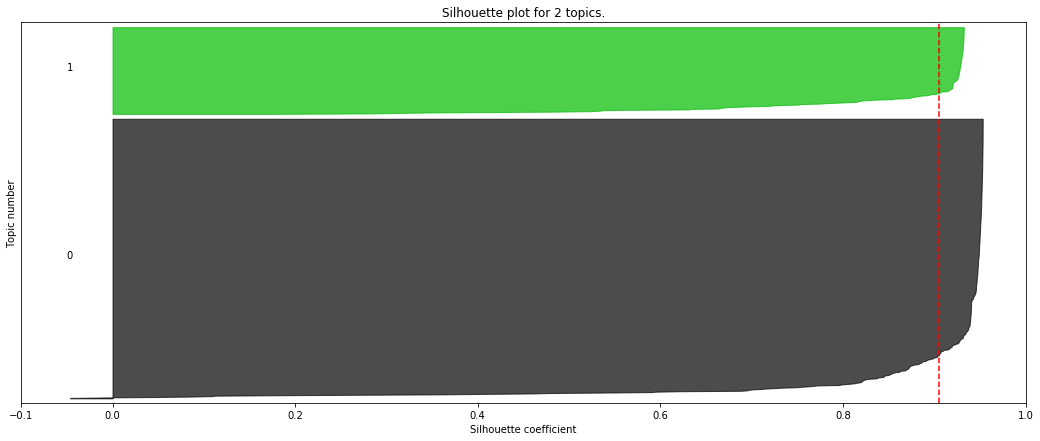

0: 0.012*"cuore" + 0.012*"venezia" + 0.011*"baciare" + 0.010*"sera" + 0.009*"livia" + 0.008*"bisognare" + 0.008*"olga" + 0.008*"marcare" + 0.007*"abbracciare" + 0.007*"addio" + 0.007*"notte" + 0.006*"viaggiare" + 0.006*"letizia" + 0.006*"mattina" + 0.006*"trieste" + 0.006*"curare" + 0.006*"ritornare" + 0.006*"salso" + 0.005*"piacere" + 0.005*"notizia"

1: 0.018*"amicare" + 0.018*"senilità" + 0.016*"parigi" + 0.015*"librare" + 0.012*"romanzare" + 0.012*"trieste" + 0.010*"articolare" + 0.009*"joyce" + 0.008*"zeno" + 0.008*"villa" + 0.008*"scrivere" + 0.008*"traduzione" + 0.007*"larbaud" + 0.007*"coscienza" + 0.007*"libro" + 0.007*"saluto" + 0.006*"piacere" + 0.006*"maestro" + 0.006*"copiare" + 0.006*"editore"

2: 0.026*"cuore" + 0.018*"sera" + 0.017*"fabbricare" + 0.015*"trieste" + 0.014*"domenica" + 0.013*"notte" + 0.013*"sabato" + 0.013*"londra" + 0.013*"marcare" + 0.011*"mattina" + 0.010*"livia" + 0.009*"letizia" + 0.009*"settimana" + 0.008*"leggere" + 0.007*"baciare" + 0.007*"notizia

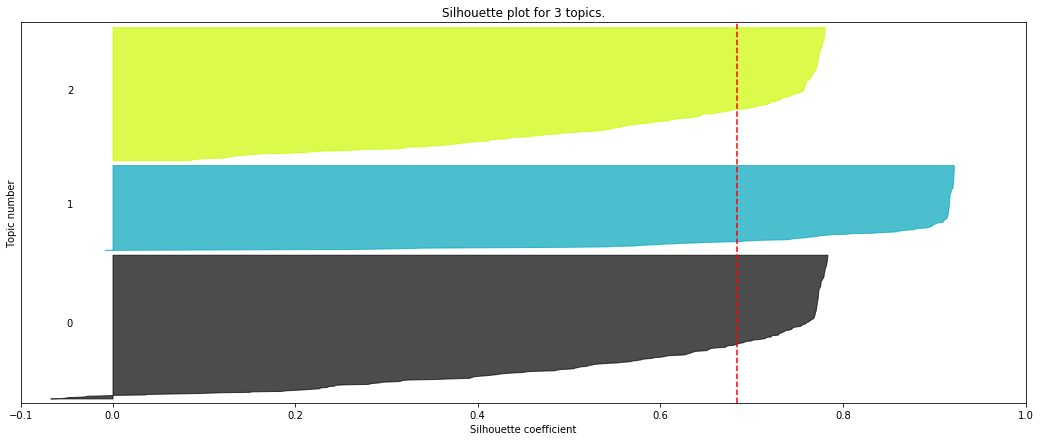

0: 0.019*"cuore" + 0.016*"venezia" + 0.015*"sera" + 0.011*"letizia" + 0.011*"marcare" + 0.010*"olga" + 0.010*"mattina" + 0.009*"notte" + 0.009*"livia" + 0.008*"bisognare" + 0.007*"abbracciare" + 0.007*"notizia" + 0.007*"trieste" + 0.007*"curare" + 0.007*"domenica" + 0.006*"baciare" + 0.006*"settimana" + 0.006*"leggere" + 0.006*"piacere" + 0.006*"ritornare"

1: 0.019*"amicare" + 0.019*"senilità" + 0.015*"parigi" + 0.015*"librare" + 0.013*"romanzare" + 0.012*"trieste" + 0.010*"joyce" + 0.010*"articolare" + 0.009*"zeno" + 0.009*"villa" + 0.009*"scrivere" + 0.008*"traduzione" + 0.008*"larbaud" + 0.007*"coscienza" + 0.007*"saluto" + 0.007*"piacere" + 0.007*"copiare" + 0.007*"editore" + 0.007*"maestro" + 0.006*"crémieux"

2: 0.026*"cuore" + 0.023*"fabbricare" + 0.016*"trieste" + 0.016*"sera" + 0.015*"marcare" + 0.014*"notte" + 0.014*"domenica" + 0.012*"sabato" + 0.011*"londra" + 0.010*"signorina" + 0.010*"mattina" + 0.009*"livia" + 0.009*"settimana" + 0.009*"leggere" + 0.009*"operare" + 0.00

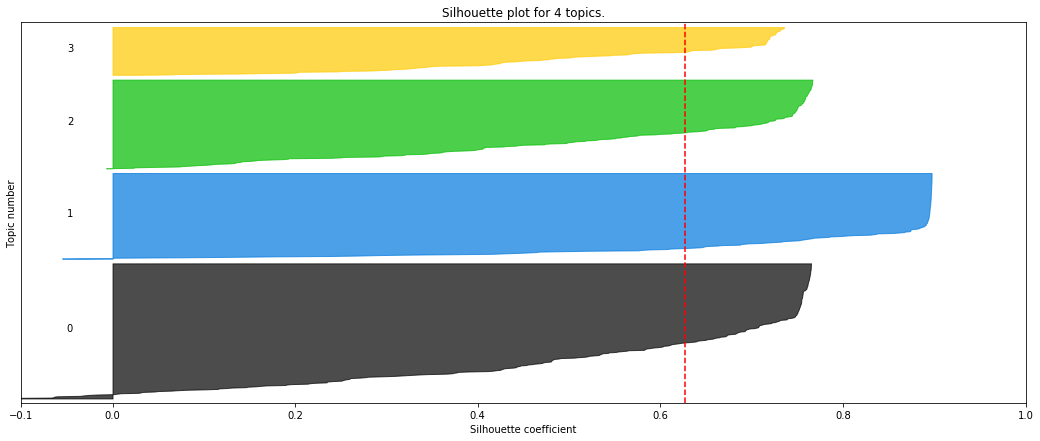

0: 0.024*"cuore" + 0.018*"sera" + 0.015*"venezia" + 0.012*"letizia" + 0.011*"trieste" + 0.011*"marcare" + 0.010*"mattina" + 0.010*"livia" + 0.010*"domenica" + 0.010*"notte" + 0.010*"olga" + 0.009*"sabato" + 0.009*"settimana" + 0.008*"notizia" + 0.007*"abbracciare" + 0.007*"bisognare" + 0.007*"piacere" + 0.007*"baciare" + 0.007*"ritornare" + 0.007*"leggere"

1: 0.021*"amicare" + 0.020*"senilità" + 0.016*"librare" + 0.016*"parigi" + 0.013*"romanzare" + 0.012*"trieste" + 0.010*"joyce" + 0.010*"articolare" + 0.009*"zeno" + 0.009*"villa" + 0.009*"scrivere" + 0.009*"traduzione" + 0.008*"larbaud" + 0.007*"coscienza" + 0.007*"libro" + 0.007*"maestro" + 0.007*"editore" + 0.007*"piacere" + 0.007*"copiare" + 0.007*"saluto"

2: 0.024*"fabbricare" + 0.019*"cuore" + 0.016*"marcare" + 0.015*"notte" + 0.014*"sera" + 0.013*"londra" + 0.013*"trieste" + 0.012*"domenica" + 0.012*"titina" + 0.010*"tchap" + 0.010*"operare" + 0.010*"macchina" + 0.008*"mattina" + 0.008*"leggere" + 0.008*"scrivere" + 0.008*"te

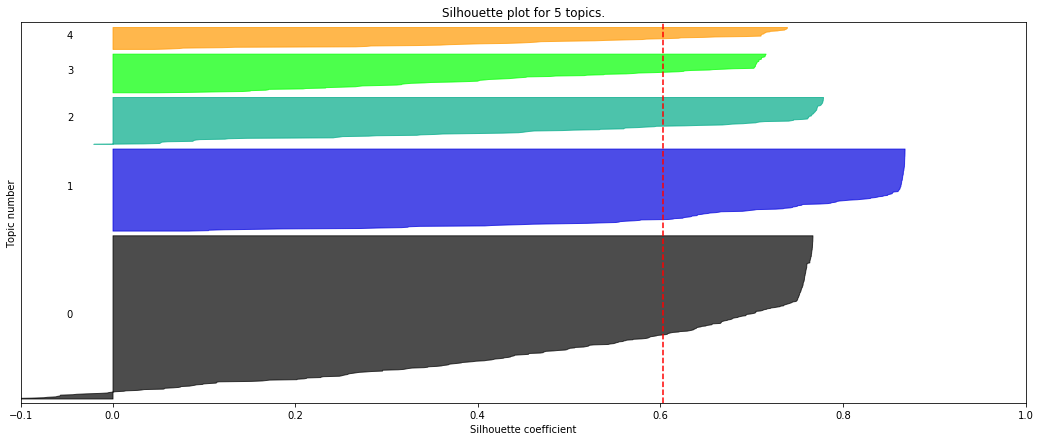

0: 0.018*"cuore" + 0.016*"venezia" + 0.015*"sera" + 0.011*"marcare" + 0.011*"letizia" + 0.009*"olga" + 0.008*"livia" + 0.008*"bisognare" + 0.008*"abbracciare" + 0.008*"notte" + 0.007*"mattina" + 0.007*"baciare" + 0.007*"ritornare" + 0.007*"salso" + 0.007*"viaggiare" + 0.007*"restare" + 0.006*"notizia" + 0.006*"pranzare" + 0.006*"domenica" + 0.006*"addio"

1: 0.021*"senilità" + 0.020*"amicare" + 0.017*"parigi" + 0.017*"librare" + 0.013*"romanzare" + 0.011*"trieste" + 0.011*"joyce" + 0.010*"articolare" + 0.010*"zeno" + 0.010*"villa" + 0.009*"scrivere" + 0.009*"traduzione" + 0.008*"larbaud" + 0.008*"coscienza" + 0.007*"maestro" + 0.007*"editore" + 0.007*"piacere" + 0.007*"saluto" + 0.007*"crémieux" + 0.007*"libro"

2: 0.025*"fabbricare" + 0.018*"cuore" + 0.014*"marcare" + 0.014*"notte" + 0.012*"sera" + 0.011*"operare" + 0.011*"tchap" + 0.010*"trieste" + 0.009*"abbracciare" + 0.009*"macchina" + 0.008*"leggere" + 0.008*"venezia" + 0.008*"londra" + 0.008*"titina" + 0.007*"signorina" + 0.007*

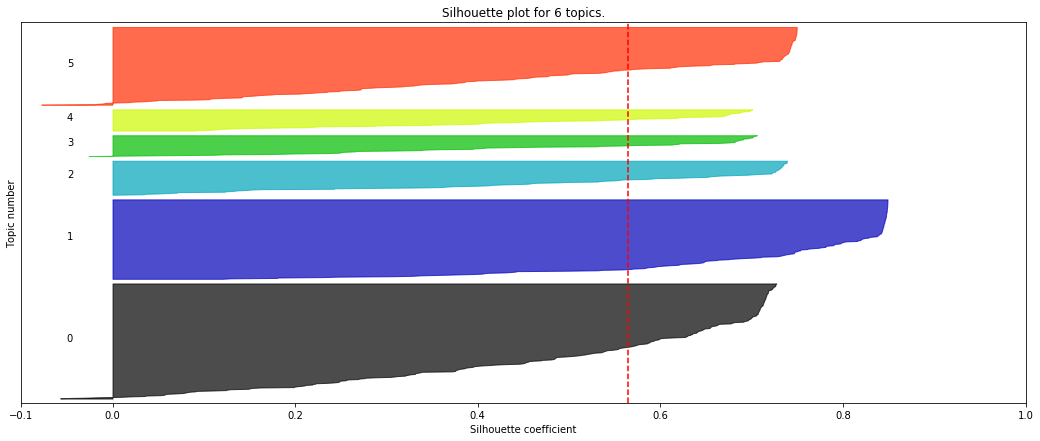

0: 0.020*"venezia" + 0.015*"sera" + 0.015*"cuore" + 0.010*"marcare" + 0.010*"olga" + 0.009*"letizia" + 0.008*"salso" + 0.007*"livia" + 0.007*"bisognare" + 0.007*"notizia" + 0.007*"ragione" + 0.007*"abbracciare" + 0.007*"pranzare" + 0.006*"baciare" + 0.006*"restare" + 0.006*"martedì" + 0.006*"ottavio" + 0.006*"frizzo" + 0.006*"salsomaggiore" + 0.006*"trieste"

1: 0.024*"amicare" + 0.024*"senilità" + 0.019*"librare" + 0.016*"parigi" + 0.016*"romanzare" + 0.012*"joyce" + 0.011*"zeno" + 0.011*"villa" + 0.011*"articolare" + 0.010*"traduzione" + 0.010*"trieste" + 0.009*"larbaud" + 0.009*"scrivere" + 0.008*"maestro" + 0.008*"coscienza" + 0.008*"piacere" + 0.008*"editore" + 0.008*"copiare" + 0.008*"italia" + 0.007*"saluto"

2: 0.022*"cuore" + 0.018*"notte" + 0.016*"fabbricare" + 0.014*"tchap" + 0.013*"marcare" + 0.011*"sera" + 0.010*"fumare" + 0.010*"testare" + 0.009*"operare" + 0.009*"domenica" + 0.009*"macchina" + 0.009*"trieste" + 0.008*"signorina" + 0.008*"leggere" + 0.008*"bepi" + 0.008*"

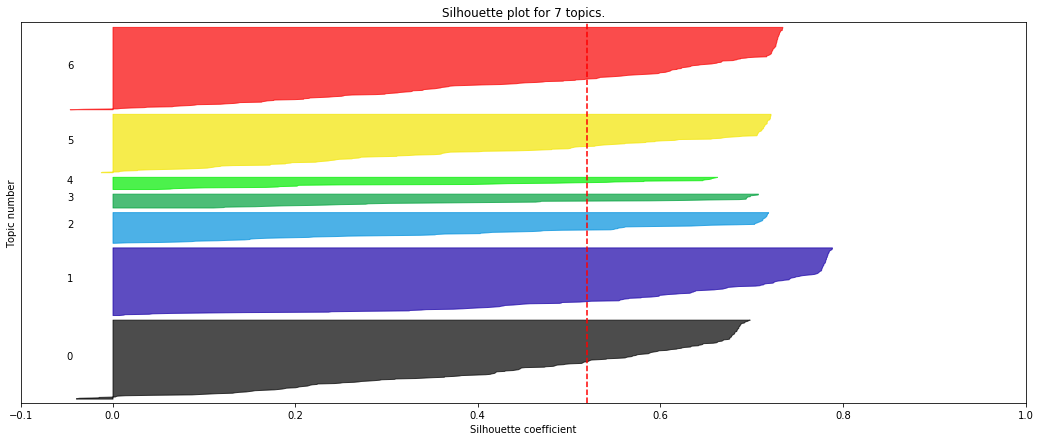

0: 0.035*"sera" + 0.025*"venezia" + 0.024*"cuore" + 0.020*"sabato" + 0.015*"marcare" + 0.014*"letizia" + 0.014*"domenica" + 0.012*"olga" + 0.012*"trieste" + 0.010*"giovedì" + 0.010*"mattina" + 0.009*"bepi" + 0.009*"settimana" + 0.008*"notizia" + 0.008*"martedì" + 0.008*"salutami" + 0.008*"frizzo" + 0.007*"arrivare" + 0.007*"pranzare" + 0.007*"treno"

1: 0.025*"amicare" + 0.025*"senilità" + 0.021*"librare" + 0.016*"romanzare" + 0.013*"parigi" + 0.012*"joyce" + 0.012*"zeno" + 0.011*"articolare" + 0.011*"villa" + 0.011*"traduzione" + 0.010*"larbaud" + 0.009*"scrivere" + 0.009*"coscienza" + 0.008*"maestro" + 0.008*"editore" + 0.008*"piacere" + 0.008*"copiare" + 0.007*"italia" + 0.007*"copia" + 0.007*"libro"

2: 0.020*"cuore" + 0.017*"fabbricare" + 0.016*"marcare" + 0.016*"notte" + 0.013*"signorina" + 0.012*"titina" + 0.009*"fumare" + 0.009*"domenica" + 0.009*"operare" + 0.009*"scrivere" + 0.008*"coiazzi" + 0.008*"caldaia" + 0.008*"tchap" + 0.008*"restare" + 0.008*"abbracciare" + 0.007*"tri

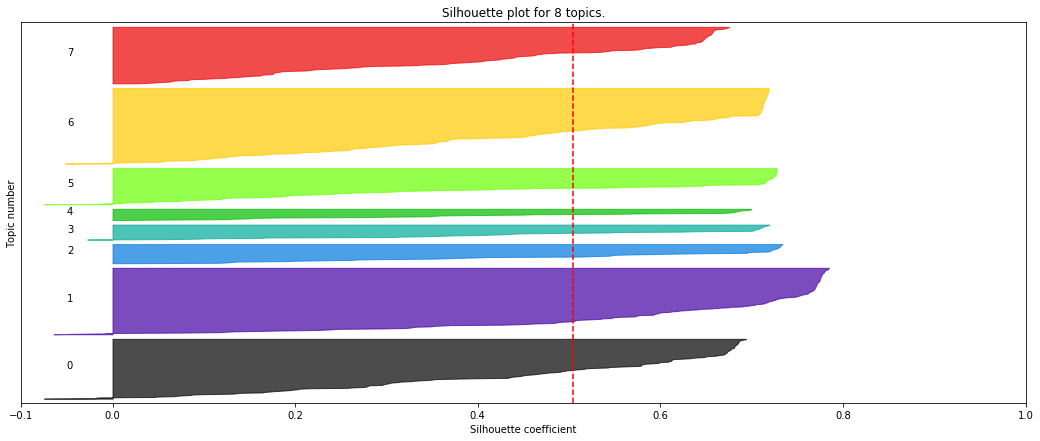

0: 0.030*"sera" + 0.025*"cuore" + 0.021*"venezia" + 0.014*"olga" + 0.013*"sabato" + 0.012*"domenica" + 0.012*"letizia" + 0.011*"marcare" + 0.011*"giovedì" + 0.010*"frizzo" + 0.009*"trieste" + 0.009*"bepi" + 0.008*"operare" + 0.008*"mattina" + 0.008*"abbracciare" + 0.008*"settimana" + 0.007*"martedì" + 0.007*"fumare" + 0.007*"pranzare" + 0.007*"testare"

1: 0.023*"senilità" + 0.022*"amicare" + 0.019*"librare" + 0.016*"parigi" + 0.015*"romanzare" + 0.012*"joyce" + 0.012*"articolare" + 0.011*"zeno" + 0.011*"villa" + 0.010*"trieste" + 0.010*"traduzione" + 0.009*"larbaud" + 0.009*"scrivere" + 0.008*"coscienza" + 0.008*"maestro" + 0.008*"piacere" + 0.008*"editore" + 0.008*"copiare" + 0.007*"italia" + 0.007*"saluto"

2: 0.031*"fabbricare" + 0.024*"notte" + 0.018*"cuore" + 0.015*"marcare" + 0.014*"macchina" + 0.014*"tchap" + 0.013*"domenica" + 0.012*"caldaia" + 0.010*"scrivere" + 0.008*"titina" + 0.008*"olga" + 0.008*"dirti" + 0.008*"pom" + 0.007*"signorina" + 0.007*"abbracciare" + 0.007*"salu

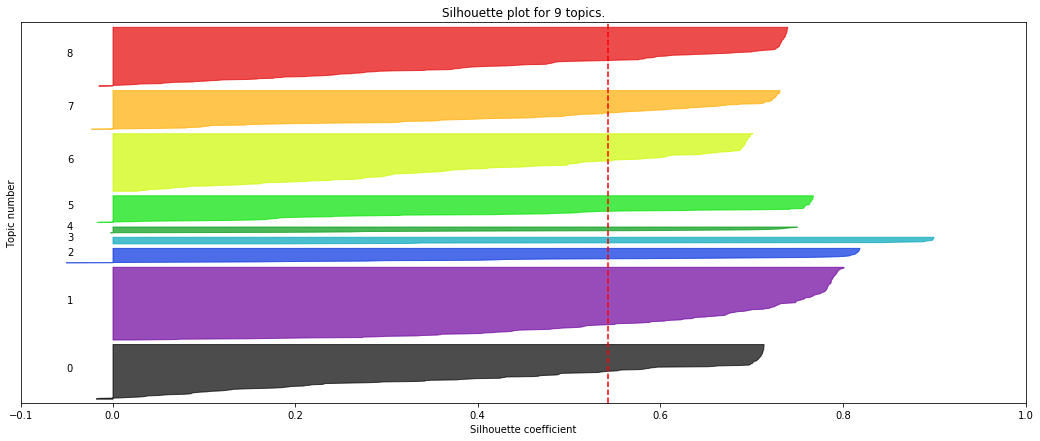

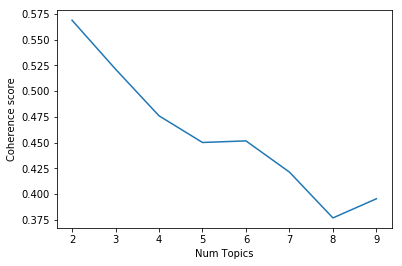

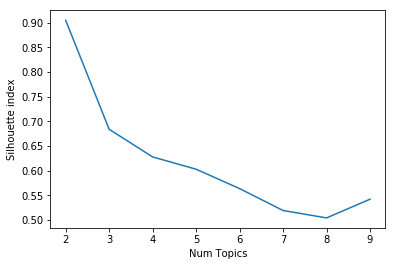

In [12]:
n_topics = 10
models_it = []
for n in range(2, n_topics):
    model_it = create_lda_model(d_it, c_it, n, passes = 200)
    assess_model_goodness(model_it, texts_it, c_it, d_it, n)
    models_it.append(model_it)

silhouette_list = [compute_silhouette(model_it, c_it, len(model_it.print_topics())) for model_it in models_it]
perplexity_list = [compute_perplexity(model_it, c_it) for model_it in models_it]
coh_v = [compute_coherence(model_it, texts_it, c_it, d_it, coherence = "c_v") for model_it in models_it]

x = range(2,n_topics)
plt.plot(x, coh_v)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.show()
plt.plot(x, silhouette_list)
plt.xlabel("Num Topics")
plt.ylabel("Silhouette index")
plt.show()

We chose the model with five topics for various reasons:

- Even though it is evident from the graphs that there are two well-divided macro-topics in the corpus, we are looking for more niche, unnoticed topics. For this reason, we decide to use a model which includes at least 5 topics for our analysis.


- The model with 5 is the one with the most meaningful division between topical words in our opinion, and since the silhouette and the coherence basically degrade by adding more topic (see also extra at the end with 40 topics), it is the safest pick given the previous constraint.


- The coherence score and silhouette index are acceptable, provided the corpus and the constraints on which we are working (heavily unbalanced set, use of dialects and multiple languages, etc.)

We set the threshold to an arbitrary high value (in our case, it was to obtain n = 500) to filter out uncertain classifications.

In [33]:
num_topics = 5
threshold = 0.733

vis = pyLDAvis.gensim.prepare(topic_model=models_it[num_topics - 2], corpus=c_it, dictionary=d_it)
pyLDAvis.display(vis)

We then created a new dataframe by adding to the original one the topic to which each letter was classified under the column `lbl` and the classification score for that topic under the column `max`.

In [34]:
X = create_paper_points_data(models_it[num_topics - 2], c_it, num_topics)
df = data_it
df["lbl"] = pd.Categorical(X.values.argmax(axis=1))
df["max"] = X.values.max(axis = 1)
df = df[df["max"] > threshold]

We can visualize that by splitting letters by topics to which they were assigned inside different dataframes and analyze those.

In [35]:
df_n = [df[df["lbl"] == n] for n in range(num_topics)]
df_n[0].describe(include="all")

,n,corpus,index,date,year,sender,senderLocation,recipient,recipientLocation,languages,mainLanguage,text,lbl,max
count,225.000000,225,225.000000,225,225.000000,225,225,225,225,225,225,225,225.0,225.000000
unique,NaN,4,NaN,222,NaN,1,9,6,14,14,1,225,1.0,NaN
top,NaN,Schmitz Livia,NaN,05/06/1913,NaN,Ettore Schmitz,Murano,Livia Veneziani,Trieste,ITA,ITA,"Alla moglie Murano, 18.3.1913 Carissima Livia...",0.0,NaN
freq,NaN,221,NaN,2,NaN,225,124,219,143,144,225,1,225.0,NaN
mean,535.702222,NaN,21.275556,NaN,1906.911111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.907587
std,177.685480,NaN,17.570637,NaN,5.669555,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.078950
min,164.000000,NaN,1.000000,NaN,1895.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.734079
25%,413.000000,NaN,8.000000,NaN,1903.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.850349
50%,564.000000,NaN,16.000000,NaN,1908.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.941927
75%,676.000000,NaN,29.000000,NaN,1911.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.969514


In [36]:
df_n[1].describe(include="all")

,n,corpus,index,date,year,sender,senderLocation,recipient,recipientLocation,languages,mainLanguage,text,lbl,max
count,145.000000,145,145.000000,145,145.000000,145,145,145,145,145,145,145,145.0,145.000000
unique,NaN,26,NaN,139,NaN,5,11,28,16,9,1,145,1.0,NaN
top,NaN,Svevo Montale,NaN,30/06/1926,NaN,Ettore Schmitz,Trieste,Ettore Schmitz,Trieste,ITA,ITA,71 Rue du Cardinal Lemoine. V 20 febbraio 25 E...,1.0,NaN
freq,NaN,54,NaN,2,NaN,105,84,40,48,92,145,1,145.0,NaN
mean,361.779310,NaN,21.096552,NaN,1926.068966,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.930819
std,367.341452,NaN,15.497009,NaN,2.985277,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.070038
min,5.000000,NaN,1.000000,NaN,1897.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.733215
25%,91.000000,NaN,9.000000,NaN,1926.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.899014
50%,133.000000,NaN,17.000000,NaN,1926.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.966178
75%,844.000000,NaN,30.000000,NaN,1927.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.980556


In [37]:
df_n[2].describe(include="all")

,n,corpus,index,date,year,sender,senderLocation,recipient,recipientLocation,languages,mainLanguage,text,lbl,max
count,65.000000,65,65.000000,65,65.000000,65,65,65,65,65,65,65,65.0,65.000000
unique,NaN,2,NaN,65,NaN,1,8,2,6,9,1,65,1.0,NaN
top,NaN,Schmitz Livia,NaN,11/08/1904,NaN,Ettore Schmitz,Murano,Livia Veneziani,Trieste,ITA,ITA,"Alla moglie [Pola, 1.10.901] Non ho ricevuta ...",2.0,NaN
freq,NaN,64,NaN,1,NaN,65,36,64,58,34,65,1,65.0,NaN
mean,503.446154,NaN,18.707692,NaN,1905.846154,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.918932
std,138.926918,NaN,18.622670,NaN,5.181791,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.072044
min,183.000000,NaN,1.000000,NaN,1896.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.733602
25%,438.000000,NaN,4.000000,NaN,1903.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.864287
50%,500.000000,NaN,12.000000,NaN,1905.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.948873
75%,559.000000,NaN,28.000000,NaN,1908.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.970759


In [38]:
df_n[3].describe(include="all") 

,n,corpus,index,date,year,sender,senderLocation,recipient,recipientLocation,languages,mainLanguage,text,lbl,max
count,43.000000,43,43.000000,43,43.000000,43,43,43,43,43,43,43,43.0,43.000000
unique,NaN,2,NaN,40,NaN,1,9,3,7,10,1,43,1.0,NaN
top,NaN,Schmitz Livia,NaN,12/07/1901,NaN,Ettore Schmitz,Trieste,Livia Veneziani,Salsomaggiore,ITA,ITA,"Alla moglie Trieste, 17.5.99 Mia cara Livia, R...",3.0,NaN
freq,NaN,41,NaN,2,NaN,43,12,41,16,24,43,1,43.0,NaN
mean,358.116279,NaN,40.651163,NaN,1901.162791,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.914950
std,108.170106,NaN,28.078024,NaN,3.054507,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.087611
min,170.000000,NaN,1.000000,NaN,1895.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.745749
25%,301.500000,NaN,11.000000,NaN,1900.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.802893
50%,363.000000,NaN,47.000000,NaN,1901.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.963052
75%,380.500000,NaN,66.500000,NaN,1901.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.986270


In [39]:
df_n[4].describe(include="all") 

,n,corpus,index,date,year,sender,senderLocation,recipient,recipientLocation,languages,mainLanguage,text,lbl,max
count,22.000000,22,22.000000,22,22.000000,22,22,22,22,22,22,22,22.0,22.000000
unique,NaN,7,NaN,22,NaN,1,3,7,4,5,1,22,1.0,NaN
top,NaN,Schmitz Livia,NaN,14/01/1901,NaN,Ettore Schmitz,Trieste,Livia Veneziani,Trieste,ITA,ITA,"Al fratello Elio Carissimo Elio, Non a pena ri...",4.0,NaN
freq,NaN,16,NaN,1,NaN,22,15,16,19,16,22,1,22.0,NaN
mean,316.590909,NaN,9.363636,NaN,1899.636364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.914722
std,203.982880,NaN,9.742130,NaN,6.918199,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.071808
min,160.000000,NaN,1.000000,NaN,1885.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.744916
25%,174.250000,NaN,2.250000,NaN,1896.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.876179
50%,191.500000,NaN,8.000000,NaN,1896.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.918428
75%,476.750000,NaN,9.000000,NaN,1904.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.979197


By having a look at the pyLDAvis graph and the topical dataframe descriptions, we chose the following names for the topics:

- The topic `family` contains matters related with the social life of Svevo, mostly with members of his family (Livia, Letizia, Olga) concerning day-to-day topics.


- The topic `literature` includes comments or discussion on the literary work of other authors or Svevo himself.


- The topic `travel` is related with the travelling of Svevo at the beginning of the 20th century, mostly for work matters. It includes dates, destinations and impressions (adjectives).


- The topic `work` concerns the period in which Svevo started working in his father-in-law industry after quitting his job at a bank. It is tightly related with travel, since he travelled mostly for work.


- The topic `health` contains a typical unformal medical lexicon (doctor, health, illness, fever, etc.). It matches in time with the period in which Svevo lost his brother and his father to illnesses, and in which Letizia was born.

In [41]:
df['lbl'] = df['lbl'].replace(0.0, 'family')
df['lbl'] = df['lbl'].replace(1.0, 'literature')
df['lbl'] = df['lbl'].replace(2.0, 'travel')
df['lbl'] = df['lbl'].replace(3.0, 'work')
df['lbl'] = df['lbl'].replace(4.0, 'health')

df.describe(include='all')
df.to_csv("datasets/svevo_with_topics.csv")

# Extra: Two-steps LDA

We tried the two-steps LDA approach proposed in [Medvet & al.(2014)](https://docs.google.com/viewer?a=v&pid=sites&srcid=ZGVmYXVsdGRvbWFpbnxtYWNoaW5lbGVhcm5pbmd0c3xneDo3YTQ5OTdjMWRkZjBiMmZm), without satisfactory results.

In [42]:
data_family = df_n[0]
texts_t0 = [preprocess_text(text, nlp_it, stop_words=stop_words, pos = ['PROPN', 'NOUN']) for text in data_family["text"]]
d_t0 = corpora.Dictionary(texts_t0)
c_t0 = [d_t0.doc2bow(text) for text in texts_t0]

0: 0.025*"moglie" + 0.015*"cuore" + 0.014*"sera" + 0.012*"venezia" + 0.008*"domenica" + 0.007*"trieste" + 0.007*"marcare" + 0.007*"olga" + 0.007*"mattina" + 0.007*"livia" + 0.007*"baciare" + 0.006*"abbracciare" + 0.006*"notizia" + 0.006*"sabato" + 0.005*"bisognare" + 0.005*"ritornare" + 0.005*"settimana" + 0.005*"giovedì" + 0.005*"titina" + 0.004*"fabbricare"

1: 0.020*"moglie" + 0.015*"cuore" + 0.012*"letizia" + 0.010*"notte" + 0.009*"sera" + 0.006*"trieste" + 0.006*"leggere" + 0.005*"olga" + 0.005*"venezia" + 0.005*"livia" + 0.005*"domenica" + 0.005*"marcare" + 0.005*"settimana" + 0.005*"mattina" + 0.004*"sabato" + 0.004*"scrivere" + 0.004*"martedì" + 0.004*"bepi" + 0.004*"piacere" + 0.004*"trovare"

For 2 topic the average silhouette score is : 0.938634404566402

Coherence: 0.20018212379828998



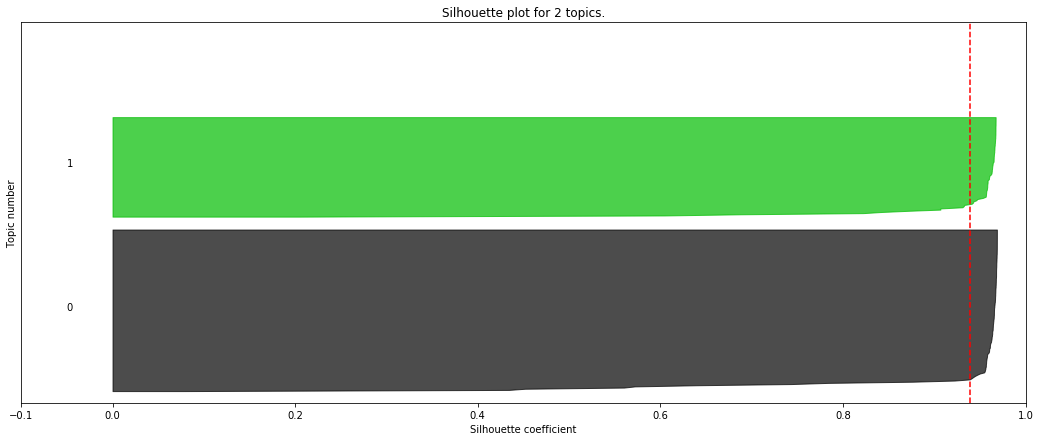

In [43]:
model_t0 = create_lda_model(d_t0, c_t0, 2, passes = 100)
assess_model_goodness(model_t0, texts_t0, c_t0, d_t0, 2)
vis = pyLDAvis.gensim.prepare(topic_model=model_t0, corpus=c_t0, dictionary=d_t0)
pyLDAvis.display(vis)

# Extra: Large LDA Models

We tried to evaluate models up to 40 topics with our previous approach, to prove that a low number of topic is best in this context.

## DO NOT EXECUTE, LONG RUNTIME!

0: 0.018*"cuore" + 0.013*"sera" + 0.010*"trieste" + 0.010*"venezia" + 0.010*"livia" + 0.010*"marcare" + 0.010*"baciare" + 0.009*"notte" + 0.008*"mattina" + 0.008*"fabbricare" + 0.008*"domenica" + 0.008*"letizia" + 0.007*"olga" + 0.007*"abbracciare" + 0.007*"viaggiare" + 0.006*"leggere" + 0.006*"notizia" + 0.006*"settimana" + 0.006*"sabato" + 0.006*"bisognare"

1: 0.017*"amicare" + 0.017*"senilità" + 0.015*"librare" + 0.015*"parigi" + 0.012*"trieste" + 0.011*"romanzare" + 0.009*"articolare" + 0.009*"joyce" + 0.008*"villa" + 0.008*"scrivere" + 0.008*"zeno" + 0.007*"traduzione" + 0.007*"maestro" + 0.007*"coscienza" + 0.007*"larbaud" + 0.006*"saluto" + 0.006*"libro" + 0.006*"piacere" + 0.006*"italia" + 0.006*"copiare"

For 2 topic the average silhouette score is : 0.9053335659430272

Coherence: 0.5687491659414248



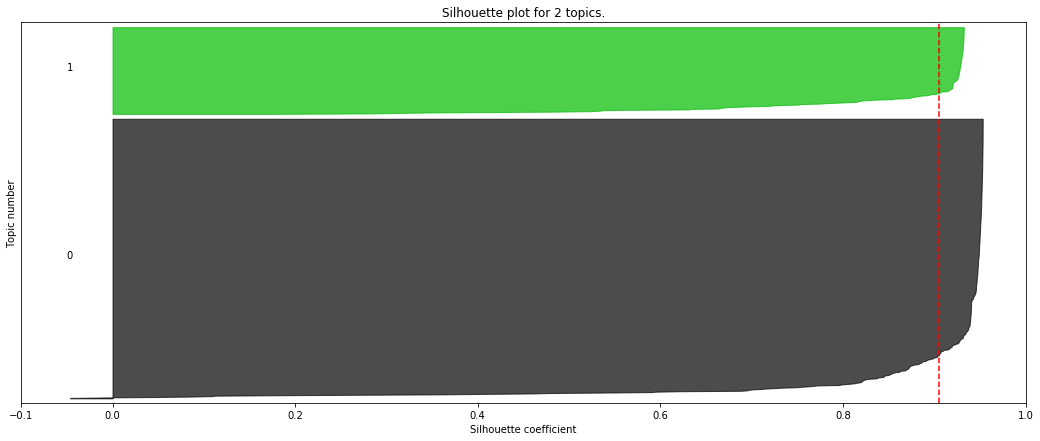

0: 0.012*"cuore" + 0.012*"venezia" + 0.011*"baciare" + 0.010*"sera" + 0.009*"livia" + 0.008*"bisognare" + 0.008*"olga" + 0.008*"marcare" + 0.007*"abbracciare" + 0.007*"addio" + 0.007*"notte" + 0.006*"viaggiare" + 0.006*"letizia" + 0.006*"mattina" + 0.006*"trieste" + 0.006*"curare" + 0.006*"ritornare" + 0.006*"salso" + 0.005*"piacere" + 0.005*"notizia"

1: 0.018*"amicare" + 0.018*"senilità" + 0.016*"parigi" + 0.015*"librare" + 0.012*"romanzare" + 0.012*"trieste" + 0.010*"articolare" + 0.009*"joyce" + 0.008*"zeno" + 0.008*"villa" + 0.008*"scrivere" + 0.008*"traduzione" + 0.007*"larbaud" + 0.007*"coscienza" + 0.007*"libro" + 0.007*"saluto" + 0.006*"piacere" + 0.006*"maestro" + 0.006*"copiare" + 0.006*"editore"

2: 0.026*"cuore" + 0.018*"sera" + 0.017*"fabbricare" + 0.015*"trieste" + 0.014*"domenica" + 0.013*"notte" + 0.013*"sabato" + 0.013*"londra" + 0.013*"marcare" + 0.011*"mattina" + 0.010*"livia" + 0.009*"letizia" + 0.009*"settimana" + 0.008*"leggere" + 0.007*"baciare" + 0.007*"notizia

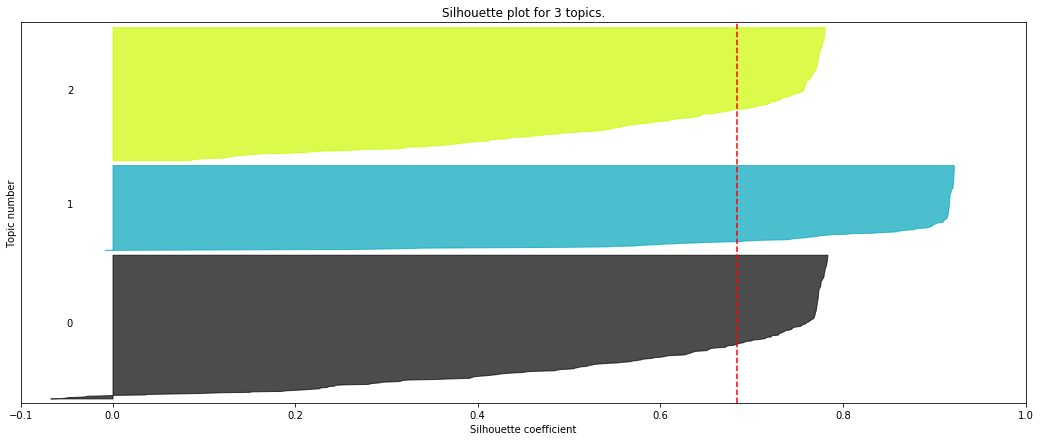

0: 0.019*"cuore" + 0.016*"venezia" + 0.015*"sera" + 0.011*"letizia" + 0.011*"marcare" + 0.010*"olga" + 0.010*"mattina" + 0.009*"notte" + 0.009*"livia" + 0.008*"bisognare" + 0.007*"abbracciare" + 0.007*"notizia" + 0.007*"trieste" + 0.007*"curare" + 0.007*"domenica" + 0.006*"baciare" + 0.006*"settimana" + 0.006*"leggere" + 0.006*"piacere" + 0.006*"ritornare"

1: 0.019*"amicare" + 0.019*"senilità" + 0.015*"parigi" + 0.015*"librare" + 0.013*"romanzare" + 0.012*"trieste" + 0.010*"joyce" + 0.010*"articolare" + 0.009*"zeno" + 0.009*"villa" + 0.009*"scrivere" + 0.008*"traduzione" + 0.008*"larbaud" + 0.007*"coscienza" + 0.007*"saluto" + 0.007*"piacere" + 0.007*"copiare" + 0.007*"editore" + 0.007*"maestro" + 0.006*"crémieux"

2: 0.026*"cuore" + 0.023*"fabbricare" + 0.016*"trieste" + 0.016*"sera" + 0.015*"marcare" + 0.014*"notte" + 0.014*"domenica" + 0.012*"sabato" + 0.011*"londra" + 0.010*"signorina" + 0.010*"mattina" + 0.009*"livia" + 0.009*"settimana" + 0.009*"leggere" + 0.009*"operare" + 0.00

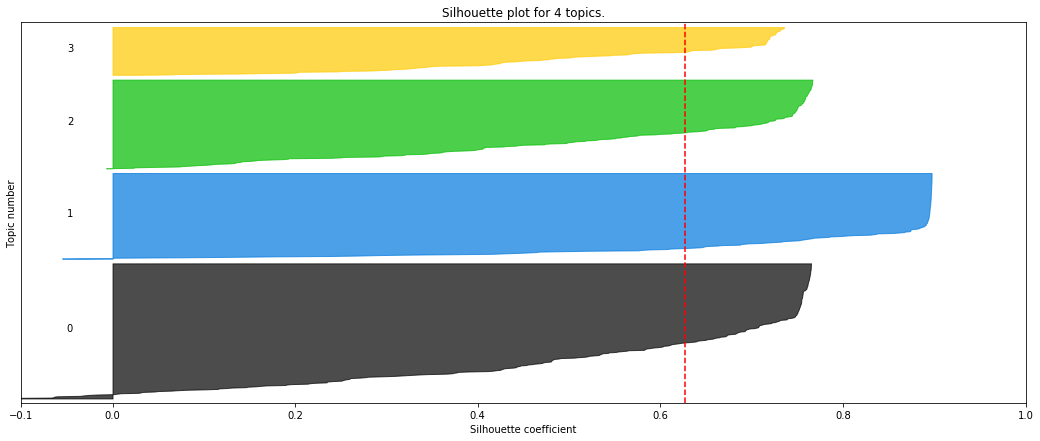

0: 0.024*"cuore" + 0.018*"sera" + 0.015*"venezia" + 0.012*"letizia" + 0.011*"trieste" + 0.011*"marcare" + 0.010*"mattina" + 0.010*"livia" + 0.010*"domenica" + 0.010*"notte" + 0.010*"olga" + 0.009*"sabato" + 0.009*"settimana" + 0.008*"notizia" + 0.007*"abbracciare" + 0.007*"bisognare" + 0.007*"piacere" + 0.007*"baciare" + 0.007*"ritornare" + 0.007*"leggere"

1: 0.021*"amicare" + 0.020*"senilità" + 0.016*"librare" + 0.016*"parigi" + 0.013*"romanzare" + 0.012*"trieste" + 0.010*"joyce" + 0.010*"articolare" + 0.009*"zeno" + 0.009*"villa" + 0.009*"scrivere" + 0.009*"traduzione" + 0.008*"larbaud" + 0.007*"coscienza" + 0.007*"libro" + 0.007*"maestro" + 0.007*"editore" + 0.007*"piacere" + 0.007*"copiare" + 0.007*"saluto"

2: 0.024*"fabbricare" + 0.019*"cuore" + 0.016*"marcare" + 0.015*"notte" + 0.014*"sera" + 0.013*"londra" + 0.013*"trieste" + 0.012*"domenica" + 0.012*"titina" + 0.010*"tchap" + 0.010*"operare" + 0.010*"macchina" + 0.008*"mattina" + 0.008*"leggere" + 0.008*"scrivere" + 0.008*"te

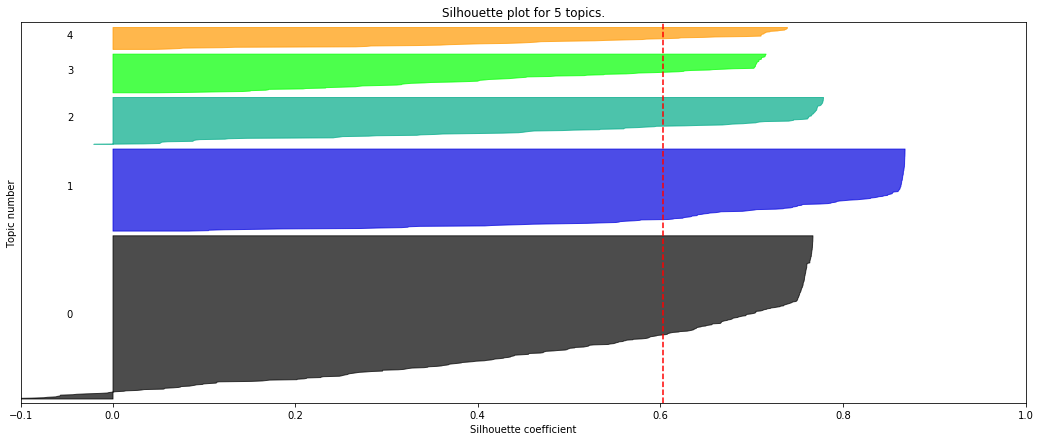

0: 0.018*"cuore" + 0.016*"venezia" + 0.015*"sera" + 0.011*"marcare" + 0.011*"letizia" + 0.009*"olga" + 0.008*"livia" + 0.008*"bisognare" + 0.008*"abbracciare" + 0.008*"notte" + 0.007*"mattina" + 0.007*"baciare" + 0.007*"ritornare" + 0.007*"salso" + 0.007*"viaggiare" + 0.007*"restare" + 0.006*"notizia" + 0.006*"pranzare" + 0.006*"domenica" + 0.006*"addio"

1: 0.021*"senilità" + 0.020*"amicare" + 0.017*"parigi" + 0.017*"librare" + 0.013*"romanzare" + 0.011*"trieste" + 0.011*"joyce" + 0.010*"articolare" + 0.010*"zeno" + 0.010*"villa" + 0.009*"scrivere" + 0.009*"traduzione" + 0.008*"larbaud" + 0.008*"coscienza" + 0.007*"maestro" + 0.007*"editore" + 0.007*"piacere" + 0.007*"saluto" + 0.007*"crémieux" + 0.007*"libro"

2: 0.025*"fabbricare" + 0.018*"cuore" + 0.014*"marcare" + 0.014*"notte" + 0.012*"sera" + 0.011*"operare" + 0.011*"tchap" + 0.010*"trieste" + 0.009*"abbracciare" + 0.009*"macchina" + 0.008*"leggere" + 0.008*"venezia" + 0.008*"londra" + 0.008*"titina" + 0.007*"signorina" + 0.007*

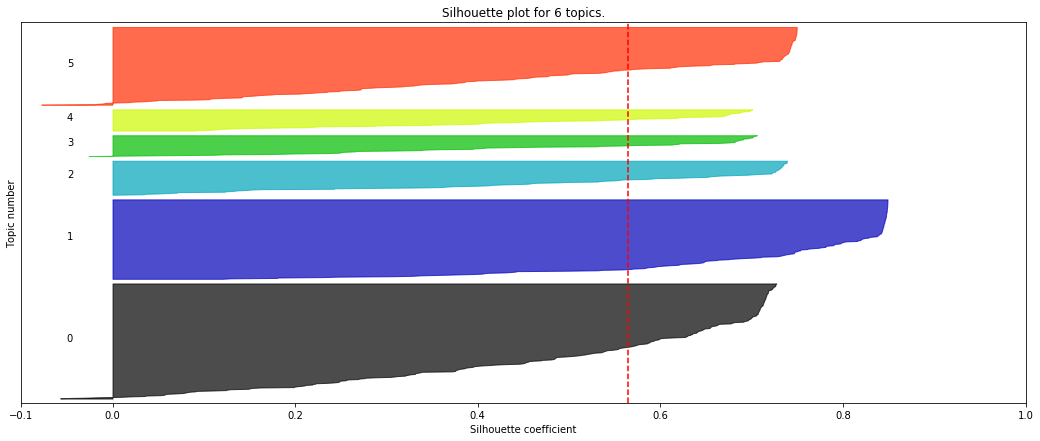

0: 0.020*"venezia" + 0.015*"sera" + 0.015*"cuore" + 0.010*"marcare" + 0.010*"olga" + 0.009*"letizia" + 0.008*"salso" + 0.007*"livia" + 0.007*"bisognare" + 0.007*"notizia" + 0.007*"ragione" + 0.007*"abbracciare" + 0.007*"pranzare" + 0.006*"baciare" + 0.006*"restare" + 0.006*"martedì" + 0.006*"ottavio" + 0.006*"frizzo" + 0.006*"salsomaggiore" + 0.006*"trieste"

1: 0.024*"amicare" + 0.024*"senilità" + 0.019*"librare" + 0.016*"parigi" + 0.016*"romanzare" + 0.012*"joyce" + 0.011*"zeno" + 0.011*"villa" + 0.011*"articolare" + 0.010*"traduzione" + 0.010*"trieste" + 0.009*"larbaud" + 0.009*"scrivere" + 0.008*"maestro" + 0.008*"coscienza" + 0.008*"piacere" + 0.008*"editore" + 0.008*"copiare" + 0.008*"italia" + 0.007*"saluto"

2: 0.022*"cuore" + 0.018*"notte" + 0.016*"fabbricare" + 0.014*"tchap" + 0.013*"marcare" + 0.011*"sera" + 0.010*"fumare" + 0.010*"testare" + 0.009*"operare" + 0.009*"domenica" + 0.009*"macchina" + 0.009*"trieste" + 0.008*"signorina" + 0.008*"leggere" + 0.008*"bepi" + 0.008*"

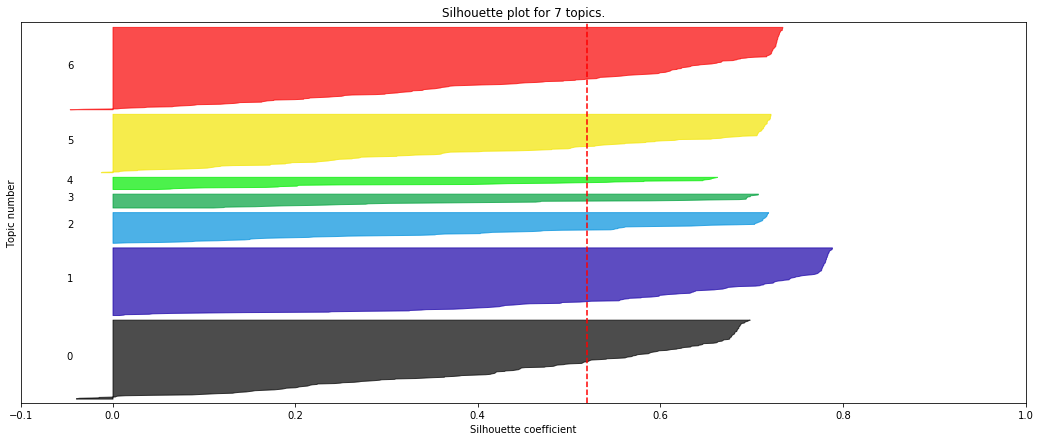

0: 0.035*"sera" + 0.025*"venezia" + 0.024*"cuore" + 0.020*"sabato" + 0.015*"marcare" + 0.014*"letizia" + 0.014*"domenica" + 0.012*"olga" + 0.012*"trieste" + 0.010*"giovedì" + 0.010*"mattina" + 0.009*"bepi" + 0.009*"settimana" + 0.008*"notizia" + 0.008*"martedì" + 0.008*"salutami" + 0.008*"frizzo" + 0.007*"arrivare" + 0.007*"pranzare" + 0.007*"treno"

1: 0.025*"amicare" + 0.025*"senilità" + 0.021*"librare" + 0.016*"romanzare" + 0.013*"parigi" + 0.012*"joyce" + 0.012*"zeno" + 0.011*"articolare" + 0.011*"villa" + 0.011*"traduzione" + 0.010*"larbaud" + 0.009*"scrivere" + 0.009*"coscienza" + 0.008*"maestro" + 0.008*"editore" + 0.008*"piacere" + 0.008*"copiare" + 0.007*"italia" + 0.007*"copia" + 0.007*"libro"

2: 0.020*"cuore" + 0.017*"fabbricare" + 0.016*"marcare" + 0.016*"notte" + 0.013*"signorina" + 0.012*"titina" + 0.009*"fumare" + 0.009*"domenica" + 0.009*"operare" + 0.009*"scrivere" + 0.008*"coiazzi" + 0.008*"caldaia" + 0.008*"tchap" + 0.008*"restare" + 0.008*"abbracciare" + 0.007*"tri

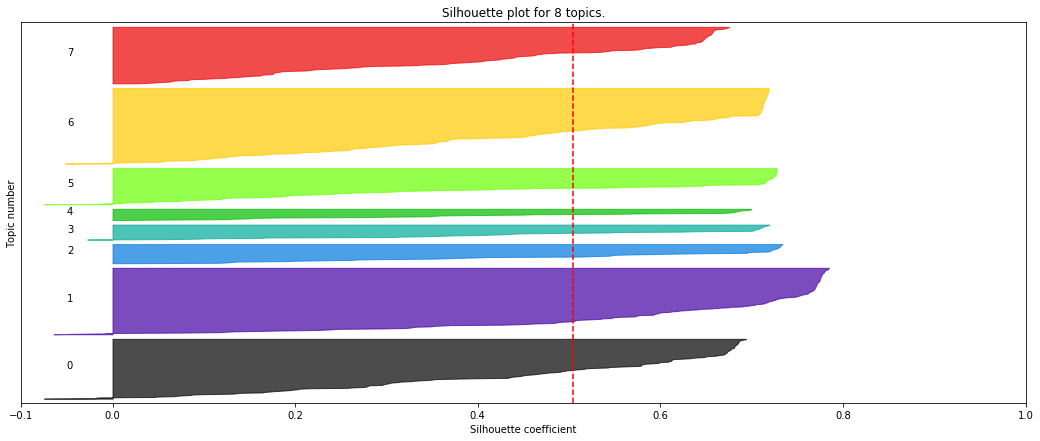

0: 0.030*"sera" + 0.025*"cuore" + 0.021*"venezia" + 0.014*"olga" + 0.013*"sabato" + 0.012*"domenica" + 0.012*"letizia" + 0.011*"marcare" + 0.011*"giovedì" + 0.010*"frizzo" + 0.009*"trieste" + 0.009*"bepi" + 0.008*"operare" + 0.008*"mattina" + 0.008*"abbracciare" + 0.008*"settimana" + 0.007*"martedì" + 0.007*"fumare" + 0.007*"pranzare" + 0.007*"testare"

1: 0.023*"senilità" + 0.022*"amicare" + 0.019*"librare" + 0.016*"parigi" + 0.015*"romanzare" + 0.012*"joyce" + 0.012*"articolare" + 0.011*"zeno" + 0.011*"villa" + 0.010*"trieste" + 0.010*"traduzione" + 0.009*"larbaud" + 0.009*"scrivere" + 0.008*"coscienza" + 0.008*"maestro" + 0.008*"piacere" + 0.008*"editore" + 0.008*"copiare" + 0.007*"italia" + 0.007*"saluto"

2: 0.031*"fabbricare" + 0.024*"notte" + 0.018*"cuore" + 0.015*"marcare" + 0.014*"macchina" + 0.014*"tchap" + 0.013*"domenica" + 0.012*"caldaia" + 0.010*"scrivere" + 0.008*"titina" + 0.008*"olga" + 0.008*"dirti" + 0.008*"pom" + 0.007*"signorina" + 0.007*"abbracciare" + 0.007*"salu

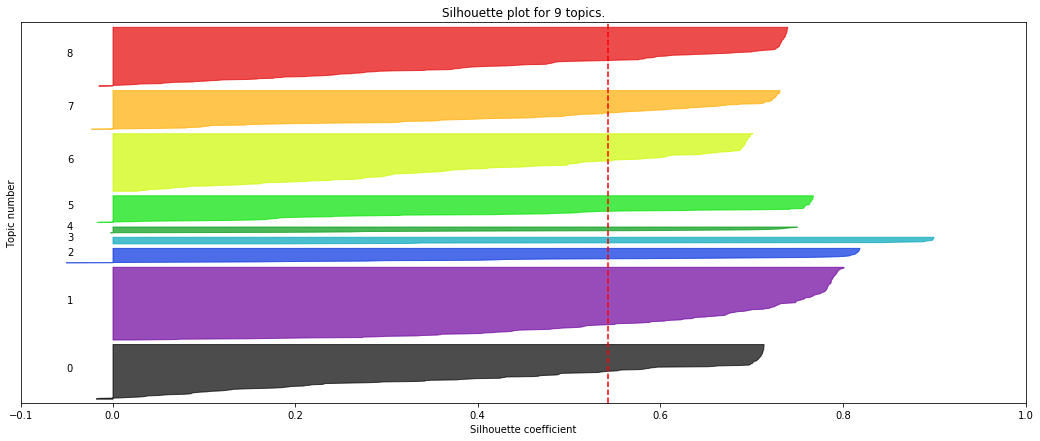

0: 0.018*"venezia" + 0.018*"sera" + 0.017*"cuore" + 0.015*"olga" + 0.012*"letizia" + 0.012*"marcare" + 0.010*"frizzo" + 0.010*"salso" + 0.009*"ottavio" + 0.008*"notizia" + 0.008*"martedì" + 0.008*"pom" + 0.007*"bisognare" + 0.007*"fumare" + 0.007*"abbracciare" + 0.007*"bagnare" + 0.007*"giovedì" + 0.007*"pranzare" + 0.006*"testare" + 0.006*"livia"

1: 0.024*"senilità" + 0.023*"amicare" + 0.019*"librare" + 0.017*"parigi" + 0.015*"romanzare" + 0.012*"joyce" + 0.011*"zeno" + 0.011*"villa" + 0.011*"articolare" + 0.010*"traduzione" + 0.010*"larbaud" + 0.009*"scrivere" + 0.009*"trieste" + 0.009*"coscienza" + 0.008*"editore" + 0.008*"maestro" + 0.008*"italia" + 0.008*"copiare" + 0.008*"crémieux" + 0.007*"saluto"

2: 0.038*"fabbricare" + 0.026*"tchap" + 0.021*"domenica" + 0.018*"cuore" + 0.015*"signorina" + 0.013*"merce" + 0.012*"olga" + 0.010*"leggere" + 0.010*"scrivere" + 0.010*"caldaia" + 0.010*"pomeriggio" + 0.009*"bepi" + 0.009*"operare" + 0.009*"marcare" + 0.008*"latta" + 0.008*"bravin" 

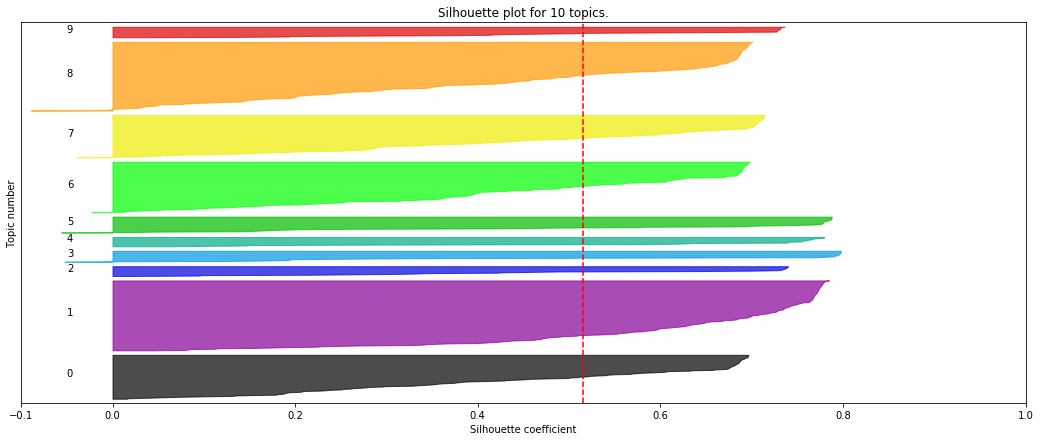

0: 0.019*"venezia" + 0.017*"sera" + 0.015*"cuore" + 0.014*"olga" + 0.013*"salso" + 0.012*"ottavio" + 0.011*"marcare" + 0.011*"giovedì" + 0.010*"letizia" + 0.010*"frizzo" + 0.007*"notizia" + 0.007*"pom" + 0.007*"banca" + 0.007*"ufficiare" + 0.007*"abbracciare" + 0.007*"piacere" + 0.006*"pranzare" + 0.006*"bisognare" + 0.006*"treno" + 0.006*"salsomaggiore"

1: 0.027*"senilità" + 0.024*"amicare" + 0.020*"librare" + 0.018*"romanzare" + 0.015*"joyce" + 0.014*"articolare" + 0.014*"zeno" + 0.011*"larbaud" + 0.011*"parigi" + 0.010*"maestro" + 0.010*"villa" + 0.009*"editore" + 0.009*"saluto" + 0.009*"piacere" + 0.008*"scrivere" + 0.008*"traduzione" + 0.008*"novello" + 0.008*"copia" + 0.008*"libro" + 0.008*"italia"

2: 0.017*"tchap" + 0.014*"bicchiere" + 0.013*"birra" + 0.013*"fondere" + 0.012*"pom" + 0.011*"fumare" + 0.011*"bestia" + 0.011*"notte" + 0.011*"bottiglia" + 0.010*"caffè" + 0.010*"scrivere" + 0.009*"fabbricare" + 0.009*"testare" + 0.009*"uomini" + 0.008*"sera" + 0.008*"cuore" + 0.008

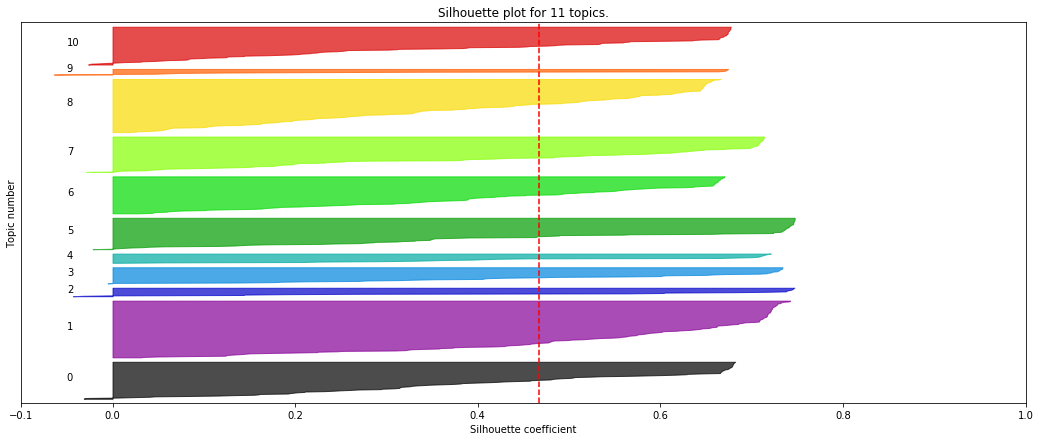

0: 0.033*"sera" + 0.022*"cuore" + 0.022*"venezia" + 0.013*"olga" + 0.011*"letizia" + 0.011*"bepi" + 0.010*"domenica" + 0.010*"sabato" + 0.010*"lira" + 0.010*"settimana" + 0.009*"trieste" + 0.009*"bagnare" + 0.009*"martedì" + 0.008*"colera" + 0.008*"giovedì" + 0.008*"ritornare" + 0.008*"abbracciare" + 0.007*"notizia" + 0.007*"viaggiare" + 0.007*"mattina"

1: 0.025*"senilità" + 0.024*"amicare" + 0.019*"librare" + 0.018*"parigi" + 0.016*"romanzare" + 0.012*"joyce" + 0.012*"zeno" + 0.011*"articolare" + 0.011*"villa" + 0.011*"traduzione" + 0.010*"trieste" + 0.010*"scrivere" + 0.010*"larbaud" + 0.009*"coscienza" + 0.009*"editore" + 0.008*"crémieux" + 0.008*"piacere" + 0.008*"libro" + 0.008*"maestro" + 0.008*"copiare"

2: 0.028*"notte" + 0.023*"fumare" + 0.016*"pom" + 0.016*"fabbricare" + 0.014*"zanzara" + 0.014*"veneziano" + 0.014*"bicchiere" + 0.013*"cuore" + 0.013*"dirti" + 0.011*"scrivere" + 0.011*"sera" + 0.010*"bontà" + 0.010*"potere" + 0.009*"letizia" + 0.009*"stanza" + 0.008*"abbracci

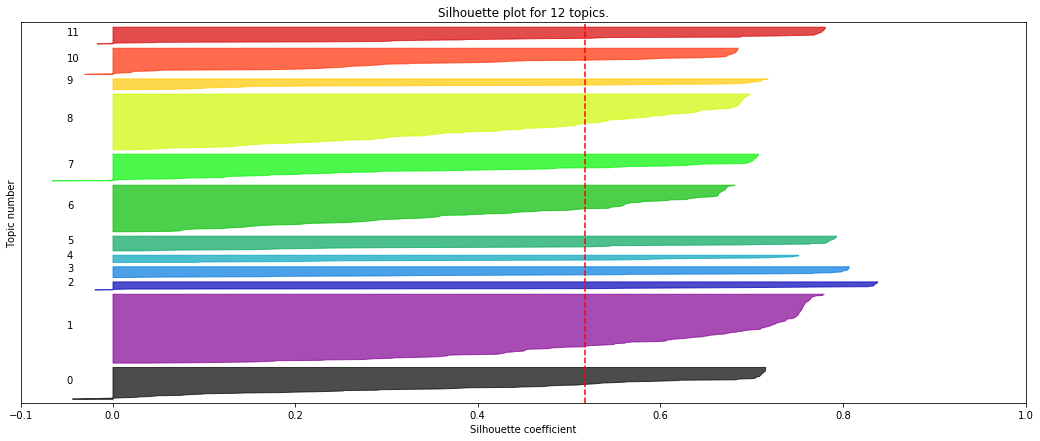

0: 0.029*"sera" + 0.027*"venezia" + 0.024*"cuore" + 0.019*"olga" + 0.019*"marcare" + 0.017*"abbracciare" + 0.013*"trieste" + 0.012*"baciare" + 0.011*"letizia" + 0.011*"sabato" + 0.010*"bepi" + 0.010*"salso" + 0.009*"viaggiare" + 0.009*"ritornare" + 0.008*"notizia" + 0.008*"frizzo" + 0.008*"giovedì" + 0.008*"domenica" + 0.007*"addio" + 0.007*"ottavio"

1: 0.030*"senilità" + 0.030*"amicare" + 0.023*"librare" + 0.023*"parigi" + 0.019*"romanzare" + 0.015*"joyce" + 0.014*"villa" + 0.014*"trieste" + 0.014*"zeno" + 0.013*"articolare" + 0.013*"traduzione" + 0.012*"larbaud" + 0.012*"scrivere" + 0.010*"maestro" + 0.010*"saluto" + 0.010*"editore" + 0.010*"italia" + 0.009*"crémieux" + 0.009*"coscienza" + 0.009*"piacere"

2: 0.024*"notte" + 0.020*"fumare" + 0.016*"fabbricare" + 0.015*"cuore" + 0.012*"piacere" + 0.012*"pom" + 0.011*"latta" + 0.011*"dirti" + 0.010*"donna" + 0.009*"mangiare" + 0.009*"testare" + 0.009*"signorina" + 0.009*"titina" + 0.008*"restare" + 0.008*"solitudine" + 0.008*"uomini" 

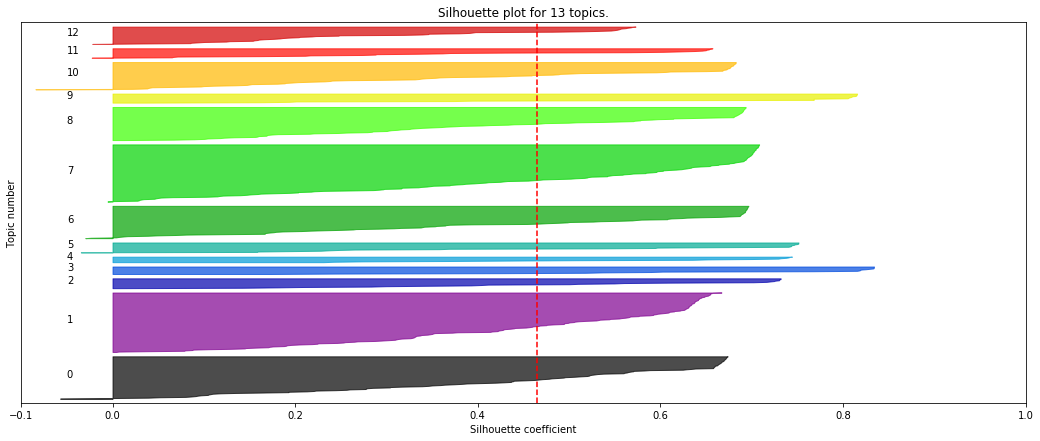

0: 0.035*"sera" + 0.028*"venezia" + 0.021*"cuore" + 0.016*"olga" + 0.013*"martedì" + 0.012*"giovedì" + 0.011*"sabato" + 0.011*"marcare" + 0.010*"domenica" + 0.009*"settimana" + 0.009*"treno" + 0.008*"trieste" + 0.008*"mezzodì" + 0.008*"arrivare" + 0.008*"notizia" + 0.008*"abbracciare" + 0.007*"paura" + 0.007*"bisognare" + 0.007*"letizia" + 0.007*"mercoledì"

1: 0.031*"amicare" + 0.029*"senilità" + 0.022*"librare" + 0.018*"joyce" + 0.016*"zeno" + 0.015*"articolare" + 0.014*"romanzare" + 0.013*"maestro" + 0.013*"larbaud" + 0.011*"villa" + 0.011*"saluto" + 0.010*"piacere" + 0.010*"parigi" + 0.010*"novello" + 0.010*"editore" + 0.009*"trieste" + 0.009*"benco" + 0.009*"convegno" + 0.008*"eugenio" + 0.008*"traduzione"

2: 0.023*"fabbricare" + 0.020*"curare" + 0.012*"zeno" + 0.011*"senilità" + 0.010*"fondere" + 0.010*"cimutti" + 0.010*"dubbio" + 0.010*"librare" + 0.010*"italiano" + 0.009*"programmare" + 0.009*"dio" + 0.009*"consenso" + 0.009*"caldaia" + 0.008*"taglio" + 0.008*"puntare" + 0.008

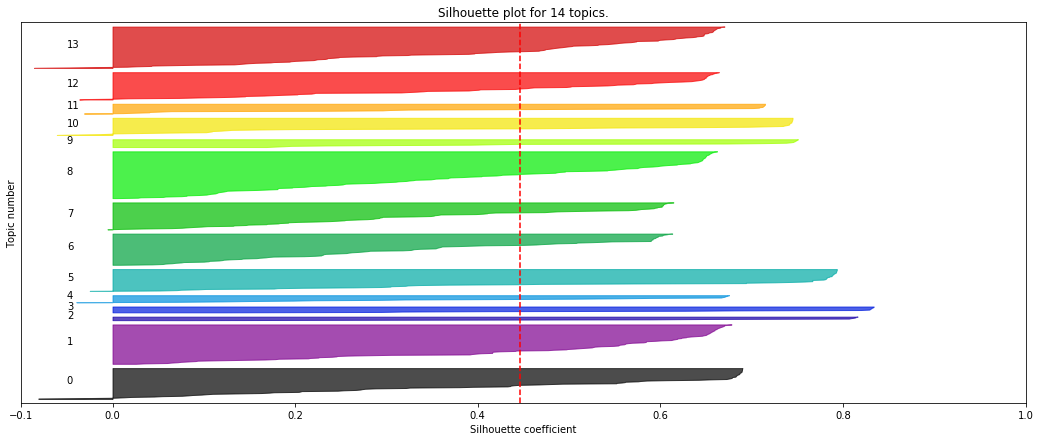

0: 0.035*"sera" + 0.030*"venezia" + 0.022*"cuore" + 0.016*"olga" + 0.013*"letizia" + 0.013*"giovedì" + 0.013*"mattina" + 0.012*"trieste" + 0.011*"domenica" + 0.010*"treno" + 0.010*"martedì" + 0.010*"abbracciare" + 0.009*"marcare" + 0.008*"arrivare" + 0.008*"leggere" + 0.008*"piacere" + 0.007*"notte" + 0.007*"biglietto" + 0.007*"pane" + 0.006*"scrivere"

1: 0.038*"senilità" + 0.024*"romanzare" + 0.024*"zeno" + 0.023*"amicare" + 0.021*"librare" + 0.015*"maestro" + 0.012*"copiare" + 0.012*"villa" + 0.012*"benco" + 0.012*"firenze" + 0.012*"larbaud" + 0.011*"articolare" + 0.011*"bobi" + 0.010*"editore" + 0.010*"joyce" + 0.010*"piacere" + 0.009*"convegno" + 0.008*"critico" + 0.008*"svevo" + 0.008*"scrivere"

2: 0.023*"fabbricare" + 0.020*"notte" + 0.018*"marcare" + 0.017*"bepi" + 0.016*"cuore" + 0.014*"signorina" + 0.012*"macchina" + 0.011*"uomini" + 0.011*"leggere" + 0.010*"letizia" + 0.010*"bravin" + 0.010*"coiazzi" + 0.010*"olga" + 0.009*"bambino" + 0.009*"notizia" + 0.009*"stazione" + 0.

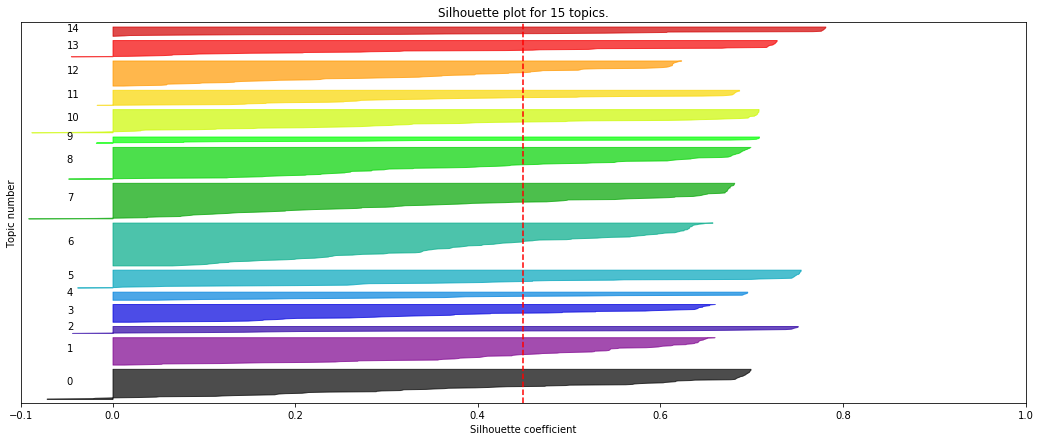

0: 0.033*"venezia" + 0.026*"sera" + 0.019*"olga" + 0.017*"marcare" + 0.017*"trieste" + 0.016*"cuore" + 0.015*"baciare" + 0.012*"domenica" + 0.012*"abbracciare" + 0.010*"ritornare" + 0.008*"salso" + 0.008*"assenza" + 0.008*"operare" + 0.008*"sabato" + 0.007*"pranzare" + 0.007*"ordine" + 0.007*"pensione" + 0.007*"settimana" + 0.006*"martedì" + 0.006*"lira"

1: 0.031*"amicare" + 0.027*"senilità" + 0.023*"librare" + 0.022*"zeno" + 0.022*"articolare" + 0.020*"joyce" + 0.016*"romanzare" + 0.014*"larbaud" + 0.014*"maestro" + 0.013*"saluto" + 0.012*"benco" + 0.010*"parigi" + 0.010*"convegno" + 0.010*"pagina" + 0.010*"editore" + 0.009*"piaggiare" + 0.009*"eugenio" + 0.009*"firenze" + 0.009*"trieste" + 0.009*"bobi"

2: 0.023*"marcare" + 0.022*"fabbricare" + 0.019*"domenica" + 0.017*"abbracciare" + 0.016*"gilda" + 0.016*"piacere" + 0.012*"cuore" + 0.011*"latta" + 0.011*"curare" + 0.010*"titina" + 0.010*"baciare" + 0.009*"viaggiare" + 0.009*"scrivere" + 0.009*"grigio" + 0.009*"fumare" + 0.009*"dio

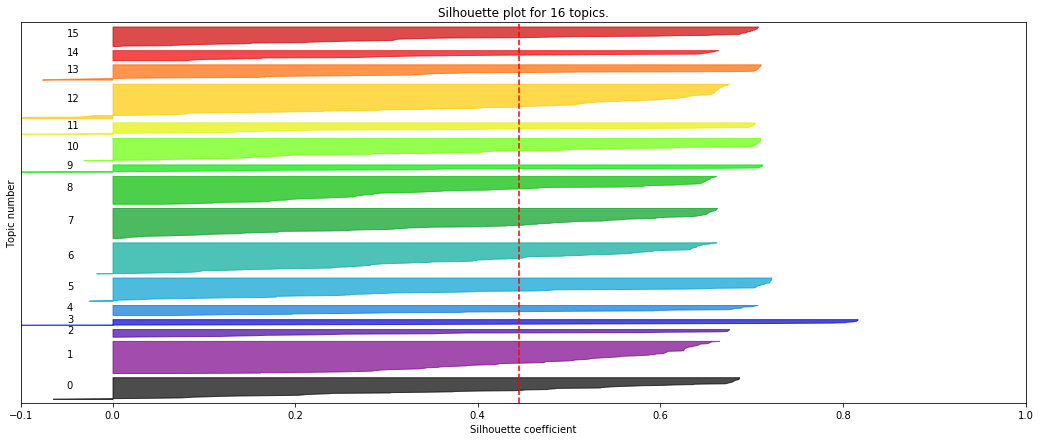

0: 0.022*"sera" + 0.018*"venezia" + 0.014*"ottavio" + 0.014*"olga" + 0.014*"frizzo" + 0.013*"marcare" + 0.012*"cuore" + 0.012*"salso" + 0.012*"martedì" + 0.009*"giovedì" + 0.009*"bisognare" + 0.008*"banca" + 0.007*"vienna" + 0.007*"abbracciare" + 0.007*"compagnia" + 0.007*"mezzodì" + 0.007*"piacere" + 0.007*"ritornare" + 0.007*"pranzare" + 0.006*"treno"

1: 0.035*"amicare" + 0.034*"senilità" + 0.026*"librare" + 0.021*"articolare" + 0.020*"joyce" + 0.016*"maestro" + 0.015*"larbaud" + 0.015*"romanzare" + 0.014*"saluto" + 0.014*"zeno" + 0.013*"editore" + 0.012*"copiare" + 0.012*"benco" + 0.012*"libro" + 0.011*"villa" + 0.011*"scrivere" + 0.010*"firenze" + 0.010*"convegno" + 0.010*"eugenio" + 0.009*"piaggiare"

2: 0.022*"fabbricare" + 0.018*"marcare" + 0.014*"uomini" + 0.013*"notizia" + 0.012*"notte" + 0.012*"olga" + 0.012*"abbracciare" + 0.011*"signorina" + 0.010*"titina" + 0.010*"bravin" + 0.010*"caldaia" + 0.010*"sera" + 0.009*"testare" + 0.009*"bambino" + 0.009*"bottone" + 0.009*"cuore

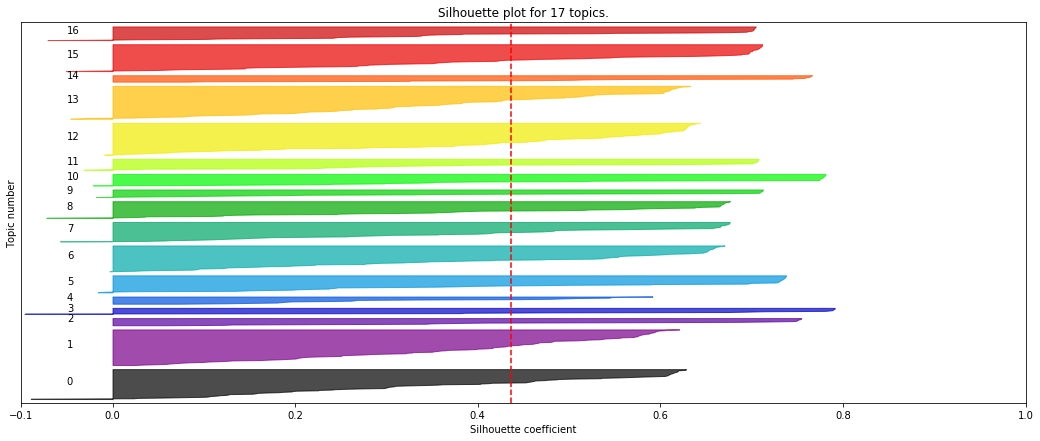

0: 0.029*"sera" + 0.018*"cuore" + 0.017*"venezia" + 0.014*"olga" + 0.013*"baciare" + 0.012*"salso" + 0.012*"giovedì" + 0.010*"abbracciare" + 0.010*"martedì" + 0.008*"partenza" + 0.008*"decisione" + 0.008*"ritornare" + 0.007*"marcare" + 0.007*"addio" + 0.006*"paura" + 0.006*"bisognare" + 0.006*"testare" + 0.006*"donna" + 0.006*"domenica" + 0.006*"veruda"

1: 0.034*"amicare" + 0.030*"senilità" + 0.022*"librare" + 0.022*"articolare" + 0.019*"joyce" + 0.017*"maestro" + 0.015*"larbaud" + 0.014*"editore" + 0.014*"romanzare" + 0.013*"benco" + 0.012*"copia" + 0.011*"saluto" + 0.011*"convegno" + 0.011*"firenze" + 0.010*"piacere" + 0.010*"eugenio" + 0.010*"piaggiare" + 0.010*"zeno" + 0.009*"bobi" + 0.009*"libro"

2: 0.020*"pom" + 0.016*"scrivere" + 0.016*"caffè" + 0.014*"fumare" + 0.014*"cuore" + 0.014*"sigaretta" + 0.014*"pensiero" + 0.011*"titina" + 0.011*"potere" + 0.011*"fabbricare" + 0.009*"veneziano" + 0.009*"colazione" + 0.009*"abbracciare" + 0.009*"lettura" + 0.009*"bagnare" + 0.009*"man

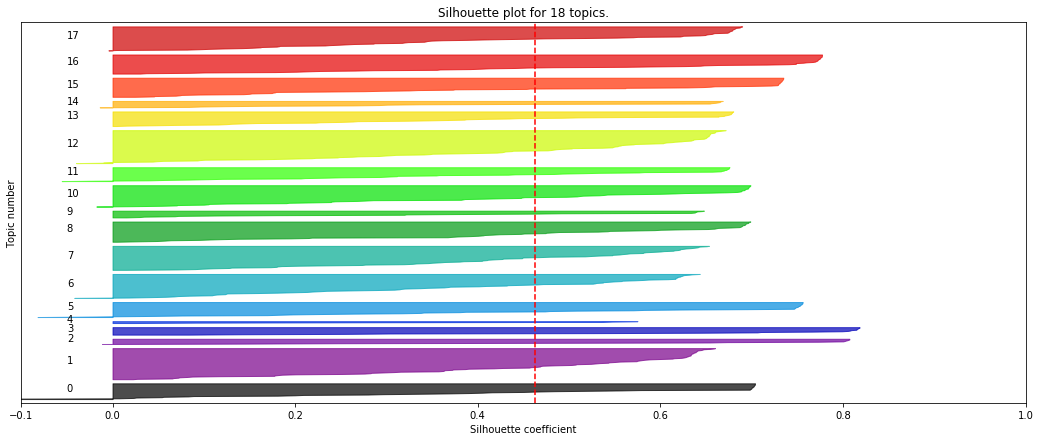

0: 0.023*"sera" + 0.021*"venezia" + 0.021*"cuore" + 0.020*"olga" + 0.014*"ritornare" + 0.011*"trieste" + 0.010*"baciare" + 0.009*"mezzodì" + 0.009*"sabato" + 0.009*"notizia" + 0.008*"operare" + 0.008*"salso" + 0.007*"abbracciare" + 0.007*"partenza" + 0.007*"assenza" + 0.007*"murare" + 0.007*"settimana" + 0.006*"fretta" + 0.006*"arrivare" + 0.006*"mercoledì"

1: 0.022*"letizia" + 0.018*"bambino" + 0.014*"studiare" + 0.013*"madre" + 0.013*"colorire" + 0.012*"ritornare" + 0.011*"uomini" + 0.011*"figliare" + 0.011*"ragione" + 0.010*"veruda" + 0.010*"pubblicare" + 0.009*"vecchio" + 0.009*"trovare" + 0.009*"fama" + 0.009*"aprile" + 0.008*"colpo" + 0.008*"scriverle" + 0.008*"parlare" + 0.008*"violare" + 0.008*"pittore"

2: 0.025*"cuore" + 0.023*"fabbricare" + 0.020*"marcare" + 0.016*"bepi" + 0.015*"titina" + 0.014*"notte" + 0.014*"rigare" + 0.013*"pom" + 0.012*"steinberg" + 0.011*"signorina" + 0.011*"notizia" + 0.011*"salutami" + 0.010*"sigaretta" + 0.010*"baciami" + 0.009*"aria" + 0.009*"cen

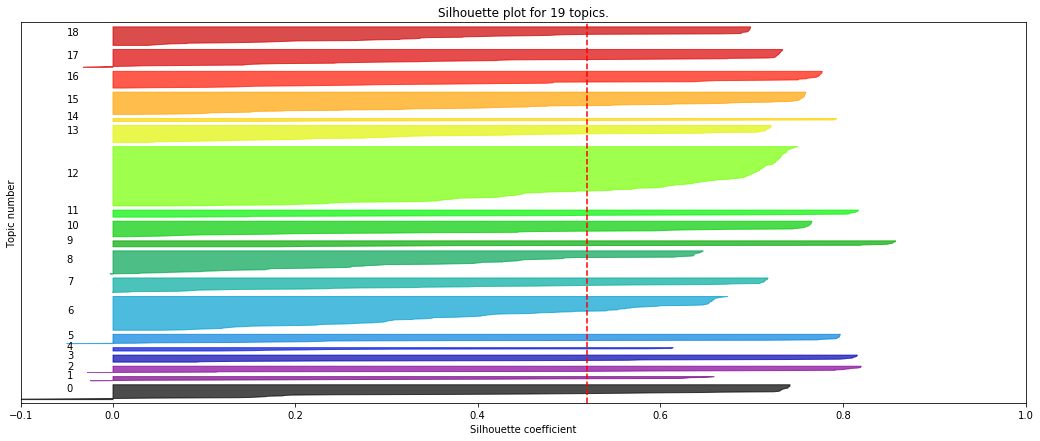

0: 0.029*"sera" + 0.019*"cuore" + 0.017*"venezia" + 0.011*"settimana" + 0.011*"domenica" + 0.011*"figliuolo" + 0.011*"marcare" + 0.010*"olga" + 0.009*"piacere" + 0.009*"bocca" + 0.009*"pom" + 0.009*"sabato" + 0.009*"causare" + 0.008*"trieste" + 0.008*"bepi" + 0.008*"testare" + 0.008*"bagnare" + 0.008*"caffè" + 0.008*"ragione" + 0.008*"letizia"

1: 0.030*"senilità" + 0.027*"amicare" + 0.024*"librare" + 0.018*"romanzare" + 0.016*"joyce" + 0.015*"articolare" + 0.015*"zeno" + 0.014*"parigi" + 0.013*"villa" + 0.013*"larbaud" + 0.011*"saluto" + 0.010*"maestro" + 0.009*"editore" + 0.009*"trieste" + 0.009*"scrivere" + 0.009*"benco" + 0.008*"traduzione" + 0.008*"copia" + 0.008*"piacere" + 0.008*"copiare"

2: 0.023*"fabbricare" + 0.018*"marcare" + 0.015*"cuore" + 0.014*"uomini" + 0.013*"signorina" + 0.013*"coiazzi" + 0.012*"domenica" + 0.012*"letizia" + 0.011*"notizia" + 0.011*"restare" + 0.011*"leggere" + 0.010*"fondere" + 0.010*"bravin" + 0.010*"bepi" + 0.010*"notte" + 0.009*"bambino" + 0.009*

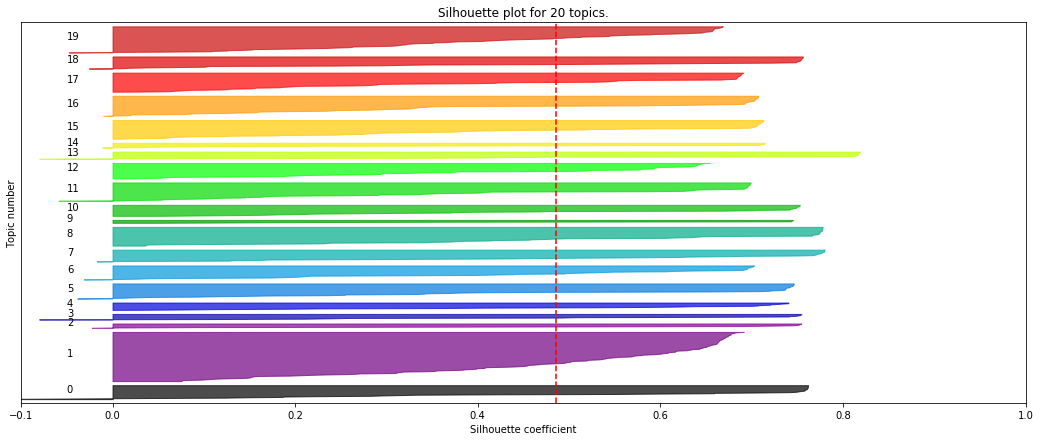

0: 0.043*"sera" + 0.033*"cuore" + 0.022*"sabato" + 0.019*"domenica" + 0.017*"marcare" + 0.016*"ottavio" + 0.015*"olga" + 0.015*"venezia" + 0.014*"frizzo" + 0.013*"notizia" + 0.012*"abbracciare" + 0.012*"fabbricare" + 0.011*"salutami" + 0.011*"sapere" + 0.011*"letizia" + 0.011*"martedì" + 0.010*"scrivere" + 0.010*"giovedì" + 0.009*"murare" + 0.009*"piacere"

1: 0.039*"senilità" + 0.030*"amicare" + 0.024*"romanzare" + 0.023*"librare" + 0.018*"zeno" + 0.018*"traduzione" + 0.014*"editore" + 0.012*"coscienza" + 0.012*"scrivere" + 0.011*"copiare" + 0.011*"maestro" + 0.010*"piacere" + 0.010*"italia" + 0.010*"libro" + 0.010*"articolare" + 0.010*"firenze" + 0.010*"pubblicazione" + 0.009*"succedere" + 0.009*"villa" + 0.009*"copia"

2: 0.028*"fumare" + 0.015*"notte" + 0.015*"donna" + 0.015*"maritare" + 0.014*"tavolo" + 0.013*"violare" + 0.013*"italia" + 0.012*"sera" + 0.012*"signorina" + 0.012*"caffè" + 0.011*"notizia" + 0.011*"steinberg" + 0.011*"ant" + 0.011*"rigare" + 0.011*"viaggiare" + 0.010

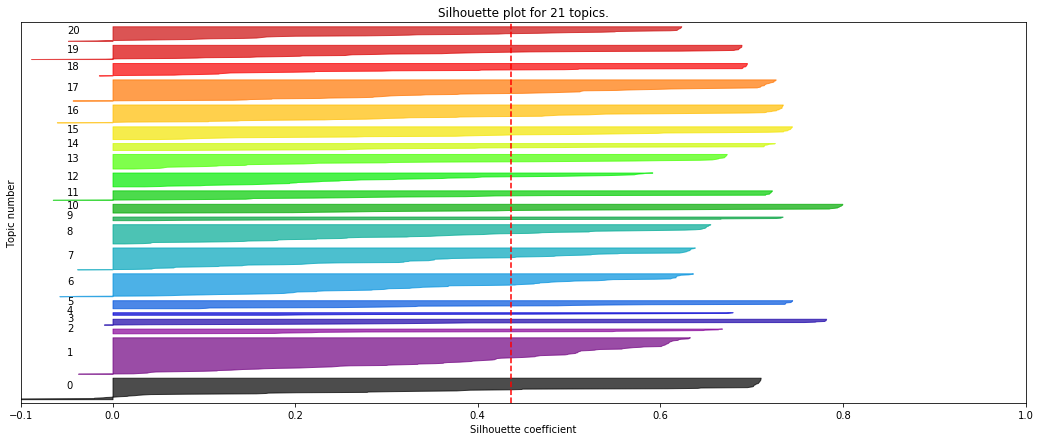

0: 0.024*"ottavio" + 0.022*"frizzo" + 0.019*"bagnare" + 0.018*"sera" + 0.018*"salso" + 0.016*"letizia" + 0.014*"cuore" + 0.014*"venezia" + 0.012*"olga" + 0.010*"pranzare" + 0.010*"piacere" + 0.010*"livia" + 0.010*"trieste" + 0.009*"natalia" + 0.009*"settembre" + 0.009*"caffè" + 0.008*"permettere" + 0.008*"paola" + 0.008*"ritornare" + 0.008*"salsomaggiore"

1: 0.031*"senilità" + 0.028*"amicare" + 0.021*"librare" + 0.017*"parigi" + 0.016*"joyce" + 0.015*"romanzare" + 0.014*"articolare" + 0.013*"traduzione" + 0.013*"zeno" + 0.013*"villa" + 0.011*"piacere" + 0.011*"maestro" + 0.011*"scrivere" + 0.011*"editore" + 0.010*"coscienza" + 0.010*"larbaud" + 0.009*"libro" + 0.009*"succedere" + 0.009*"saluto" + 0.009*"italia"

2: 0.036*"signorina" + 0.023*"fabbricare" + 0.023*"fumare" + 0.020*"cuore" + 0.017*"notte" + 0.017*"piacere" + 0.017*"letizia" + 0.016*"coiazzi" + 0.014*"dottore" + 0.013*"abbracciare" + 0.012*"bravin" + 0.011*"uomini" + 0.010*"domenica" + 0.010*"restare" + 0.010*"sera" + 0.01

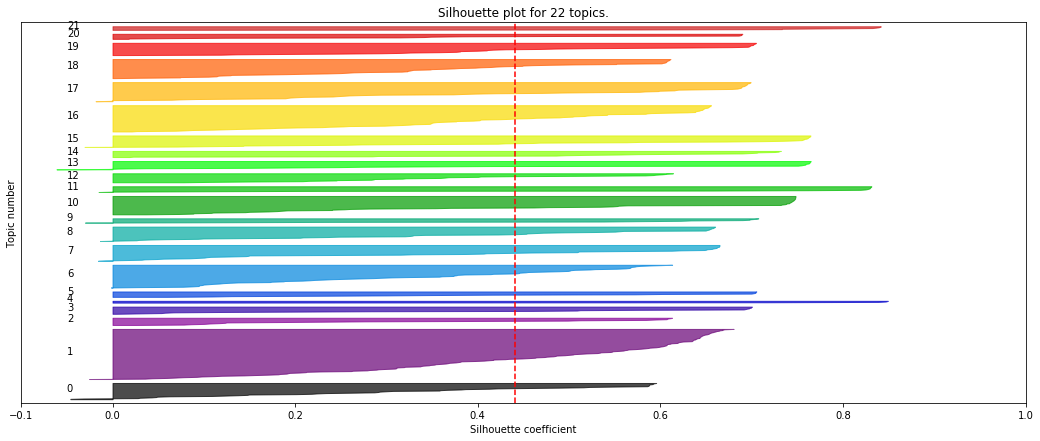

0: 0.045*"sera" + 0.033*"cuore" + 0.020*"letizia" + 0.020*"frizzo" + 0.018*"ottavio" + 0.017*"venezia" + 0.016*"abbracciare" + 0.014*"olga" + 0.013*"sabato" + 0.012*"giovedì" + 0.012*"settimana" + 0.011*"salso" + 0.011*"marcare" + 0.010*"settembre" + 0.010*"cenare" + 0.009*"pranzare" + 0.009*"vienna" + 0.009*"paura" + 0.009*"domenica" + 0.009*"bepi"

1: 0.040*"senilità" + 0.033*"amicare" + 0.026*"librare" + 0.021*"romanzare" + 0.020*"zeno" + 0.016*"joyce" + 0.015*"editore" + 0.015*"articolare" + 0.014*"maestro" + 0.012*"copiare" + 0.011*"parigi" + 0.011*"larbaud" + 0.011*"italia" + 0.011*"scrivere" + 0.011*"saluto" + 0.011*"copia" + 0.010*"libro" + 0.010*"traduzione" + 0.010*"coscienza" + 0.009*"convegno"

2: 0.033*"fumare" + 0.020*"fabbricare" + 0.018*"bravin" + 0.017*"sigaretta" + 0.017*"uomini" + 0.017*"notte" + 0.016*"tono" + 0.014*"pensiero" + 0.014*"cuore" + 0.013*"vecchio" + 0.012*"abbracciare" + 0.011*"tchaperoff" + 0.011*"coiazzi" + 0.010*"leggere" + 0.010*"italia" + 0.010*"on

For 23 topic the average silhouette score is : 0.4373567816882926

Coherence: 0.3607096331162257



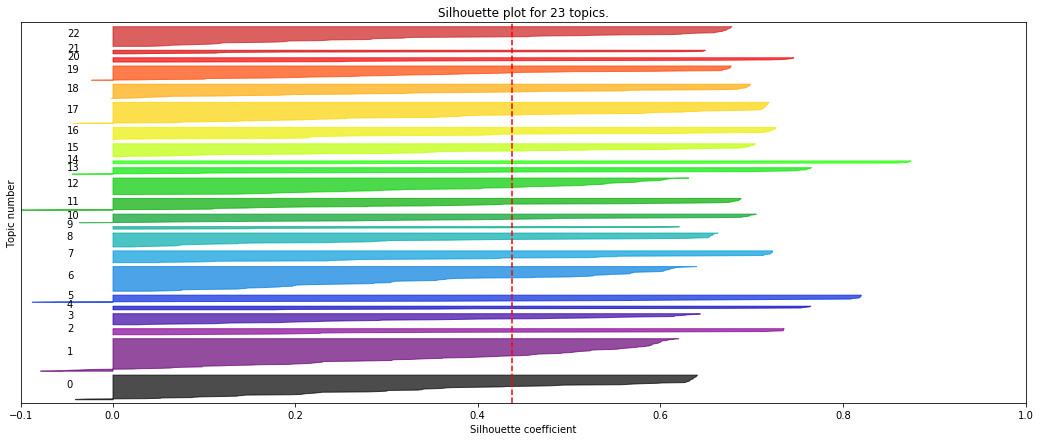

0: 0.015*"sera" + 0.013*"cuore" + 0.012*"venezia" + 0.012*"olga" + 0.011*"questione" + 0.011*"baciare" + 0.009*"dolore" + 0.009*"ragione" + 0.009*"fondere" + 0.009*"salso" + 0.008*"donna" + 0.008*"dubbio" + 0.008*"maritare" + 0.008*"dimissione" + 0.007*"marcare" + 0.007*"ufficiare" + 0.007*"ordine" + 0.007*"abbracciare" + 0.007*"assenza" + 0.007*"campagna"

1: 0.035*"amicare" + 0.029*"romanzare" + 0.026*"senilità" + 0.023*"parigi" + 0.021*"articolare" + 0.017*"joyce" + 0.017*"trieste" + 0.017*"villa" + 0.015*"saluto" + 0.014*"larbaud" + 0.013*"novello" + 0.012*"zeno" + 0.012*"librare" + 0.012*"londra" + 0.011*"copiare" + 0.011*"svevo" + 0.010*"pagina" + 0.010*"letteratura" + 0.010*"marzo" + 0.009*"aff"

2: 0.027*"fabbricare" + 0.027*"pasini" + 0.026*"professore" + 0.021*"zanzara" + 0.019*"riga" + 0.018*"bepi" + 0.016*"baciare" + 0.015*"abbracciare" + 0.014*"seccatura" + 0.013*"curare" + 0.013*"settimana" + 0.011*"lettura" + 0.010*"olga" + 0.010*"cuore" + 0.009*"ordine" + 0.009*"novembr

For 24 topic the average silhouette score is : 0.4405838349383886

Coherence: 0.3887679869202079



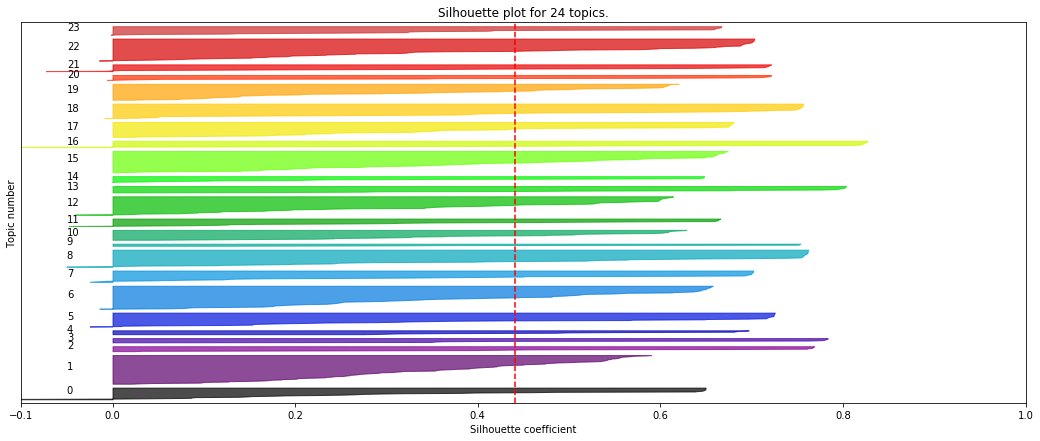

0: 0.044*"sera" + 0.023*"cuore" + 0.021*"frizzo" + 0.019*"letizia" + 0.019*"ottavio" + 0.017*"martedì" + 0.015*"venezia" + 0.012*"domenica" + 0.011*"salso" + 0.010*"olga" + 0.010*"piacere" + 0.010*"natalia" + 0.010*"giovedì" + 0.009*"cenare" + 0.009*"pranzare" + 0.009*"sabato" + 0.009*"bepi" + 0.008*"settembre" + 0.008*"paola" + 0.008*"testare"

1: 0.028*"amicare" + 0.022*"joyce" + 0.019*"articolare" + 0.018*"saluto" + 0.017*"senilità" + 0.016*"firenze" + 0.014*"piacere" + 0.014*"amico" + 0.014*"parigi" + 0.013*"mese" + 0.012*"studiare" + 0.012*"maestro" + 0.011*"editore" + 0.010*"roba" + 0.010*"romanzare" + 0.010*"librare" + 0.010*"larbaud" + 0.009*"pagina" + 0.009*"bemporad" + 0.009*"bobi"

2: 0.029*"fabbricare" + 0.016*"grigio" + 0.015*"zia" + 0.015*"tchap" + 0.015*"onta" + 0.015*"bravin" + 0.015*"uomini" + 0.014*"coiazzi" + 0.013*"cuore" + 0.013*"signorina" + 0.012*"bambino" + 0.012*"tono" + 0.012*"esitazione" + 0.012*"domenica" + 0.012*"vaso" + 0.012*"piacere" + 0.011*"puntare" + 

For 25 topic the average silhouette score is : 0.4261635623691992

Coherence: 0.4041711913152599



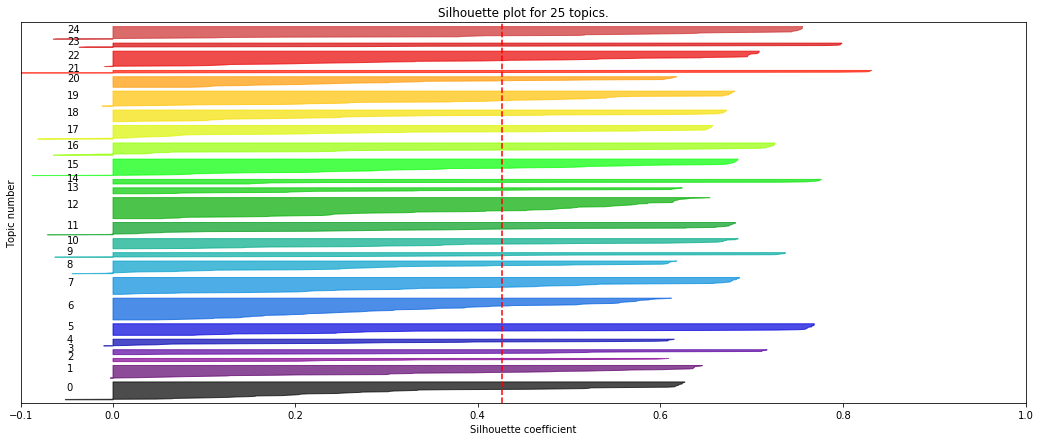

0: 0.026*"sera" + 0.022*"cuore" + 0.017*"olga" + 0.017*"salso" + 0.015*"frizzo" + 0.014*"venezia" + 0.012*"caffè" + 0.012*"bagnare" + 0.011*"letizia" + 0.009*"treno" + 0.009*"settembre" + 0.008*"abbracciare" + 0.008*"mezzodì" + 0.008*"pom" + 0.008*"ritornare" + 0.008*"pranzare" + 0.008*"ottavio" + 0.008*"piacere" + 0.008*"pepe" + 0.008*"bepi"

1: 0.025*"vino" + 0.022*"cuore" + 0.019*"letizia" + 0.013*"colorire" + 0.013*"piacere" + 0.012*"roba" + 0.012*"veruda" + 0.012*"amico" + 0.011*"studiare" + 0.010*"settimana" + 0.010*"ricordare" + 0.009*"pubblicare" + 0.009*"paura" + 0.009*"pittore" + 0.009*"osservazione" + 0.008*"cenare" + 0.008*"fama" + 0.008*"difficoltà" + 0.008*"ragione" + 0.008*"londra"

2: 0.063*"curare" + 0.018*"freud" + 0.018*"cura" + 0.017*"fabbricare" + 0.015*"marcare" + 0.015*"pom" + 0.013*"guaio" + 0.013*"succedere" + 0.012*"librare" + 0.011*"veneziano" + 0.011*"questione" + 0.011*"averne" + 0.011*"senilità" + 0.010*"fumare" + 0.010*"condizione" + 0.010*"zeno" + 0.010*

For 26 topic the average silhouette score is : 0.45894899574470804

Coherence: 0.3821645446953603



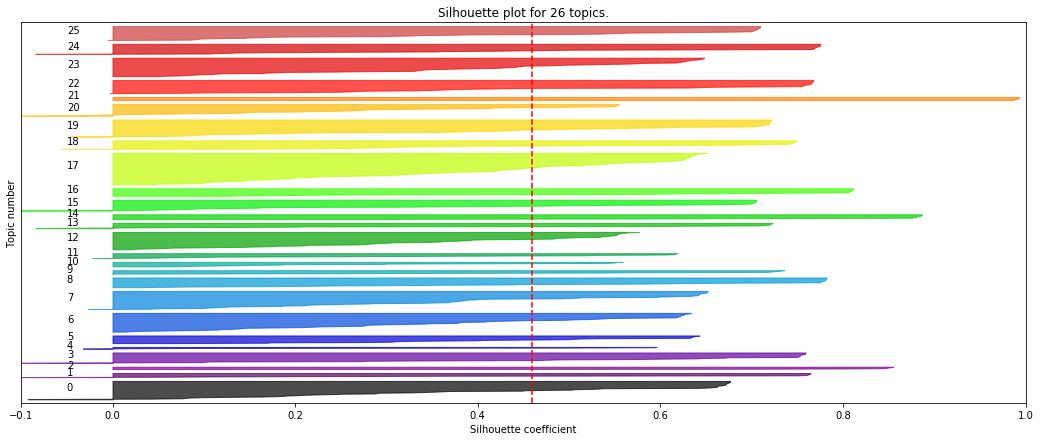

0: 0.034*"sera" + 0.026*"frizzo" + 0.020*"letizia" + 0.018*"salso" + 0.017*"cuore" + 0.015*"ottavio" + 0.014*"sabato" + 0.014*"venezia" + 0.014*"marcare" + 0.014*"olga" + 0.012*"settembre" + 0.011*"martedì" + 0.011*"pranzare" + 0.011*"bagnare" + 0.010*"giovedì" + 0.009*"testare" + 0.009*"baciare" + 0.008*"fabbricare" + 0.008*"pepe" + 0.008*"leggere"

1: 0.036*"amicare" + 0.034*"senilità" + 0.027*"romanzare" + 0.024*"librare" + 0.018*"traduzione" + 0.018*"joyce" + 0.016*"copiare" + 0.015*"maestro" + 0.014*"scrivere" + 0.013*"convegno" + 0.013*"coscienza" + 0.013*"zeno" + 0.013*"libro" + 0.012*"pubblicazione" + 0.012*"italia" + 0.012*"villa" + 0.012*"pagina" + 0.012*"larbaud" + 0.011*"bobi" + 0.010*"notizia"

2: 0.025*"fabbricare" + 0.021*"caffè" + 0.019*"uomini" + 0.016*"signorina" + 0.015*"coiazzi" + 0.015*"tono" + 0.014*"bravin" + 0.014*"fumare" + 0.013*"leggere" + 0.013*"grigio" + 0.012*"notte" + 0.012*"camicia" + 0.012*"febbre" + 0.011*"vento" + 0.011*"bambino" + 0.010*"vecchio" + 0

For 27 topic the average silhouette score is : 0.4480114053344326

Coherence: 0.38085136370964673



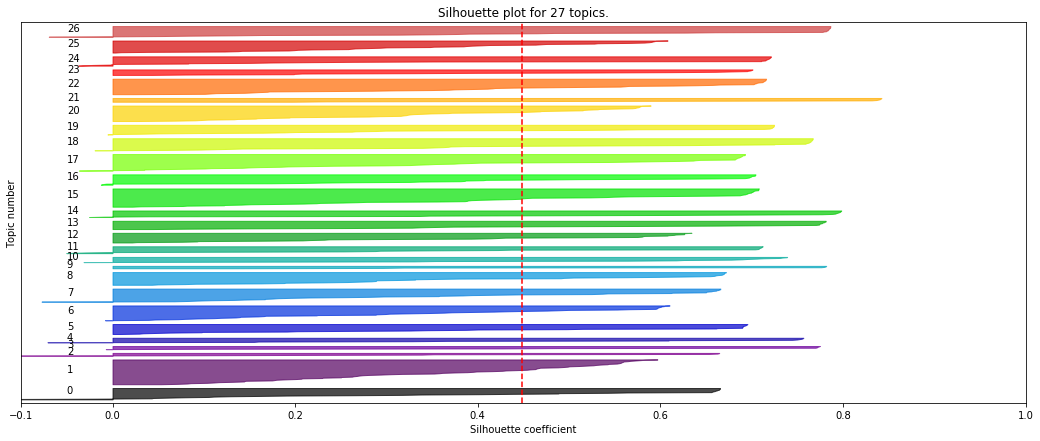

0: 0.045*"sera" + 0.030*"cuore" + 0.024*"sabato" + 0.016*"letizia" + 0.014*"treno" + 0.014*"mattina" + 0.013*"domenica" + 0.013*"venezia" + 0.012*"trieste" + 0.012*"martedì" + 0.010*"scrivere" + 0.010*"olga" + 0.010*"notizia" + 0.009*"marcare" + 0.009*"settimana" + 0.009*"caffè" + 0.009*"fabbricare" + 0.008*"giovedì" + 0.008*"pranzare" + 0.008*"gatto"

1: 0.037*"amicare" + 0.023*"articolare" + 0.022*"senilità" + 0.020*"librare" + 0.020*"joyce" + 0.019*"saluto" + 0.019*"editore" + 0.017*"maestro" + 0.017*"larbaud" + 0.016*"parigi" + 0.015*"romanzare" + 0.013*"convegno" + 0.013*"piacere" + 0.013*"eugenio" + 0.013*"firenze" + 0.012*"trieste" + 0.012*"novello" + 0.011*"piaggiare" + 0.010*"aff" + 0.010*"zeno"

2: 0.021*"cuore" + 0.020*"sera" + 0.017*"marcare" + 0.016*"notte" + 0.014*"zanzara" + 0.014*"dispaccio" + 0.013*"fabbricare" + 0.013*"settimana" + 0.012*"trieste" + 0.012*"titina" + 0.011*"lunedi" + 0.010*"domenica" + 0.010*"solitudine" + 0.009*"bepi" + 0.008*"dirti" + 0.008*"trovare"

For 28 topic the average silhouette score is : 0.4610228568880924

Coherence: 0.3774341237355966



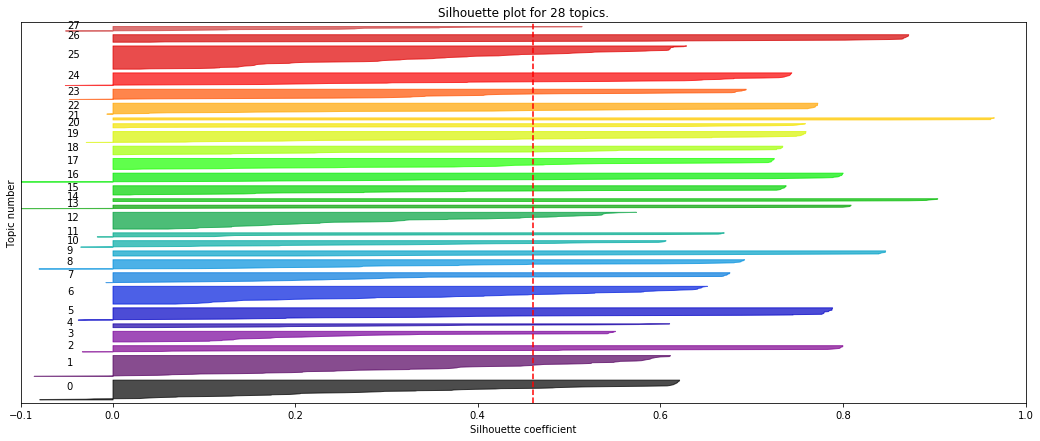

0: 0.020*"cuore" + 0.017*"sera" + 0.016*"venezia" + 0.015*"ritornare" + 0.013*"trieste" + 0.012*"parigi" + 0.011*"baciare" + 0.011*"marcare" + 0.010*"sabato" + 0.010*"olga" + 0.010*"abbracciare" + 0.009*"partenza" + 0.008*"paura" + 0.008*"salso" + 0.007*"mezzodì" + 0.007*"bepi" + 0.007*"posto" + 0.007*"notizia" + 0.007*"pensiero" + 0.007*"figliuolo"

1: 0.035*"amicare" + 0.033*"senilità" + 0.026*"librare" + 0.021*"articolare" + 0.019*"joyce" + 0.017*"romanzare" + 0.016*"larbaud" + 0.015*"maestro" + 0.014*"editore" + 0.013*"zeno" + 0.012*"saluto" + 0.011*"copiare" + 0.011*"trieste" + 0.011*"villa" + 0.010*"firenze" + 0.010*"convegno" + 0.010*"traduzione" + 0.009*"critico" + 0.009*"parigi" + 0.009*"novello"

2: 0.024*"curare" + 0.022*"taglio" + 0.016*"sventura" + 0.014*"leggere" + 0.013*"zeno" + 0.011*"esitazione" + 0.011*"bontà" + 0.011*"trieste" + 0.009*"augurio" + 0.009*"artista" + 0.009*"dispaccio" + 0.009*"dubbio" + 0.009*"giornata" + 0.009*"puntare" + 0.008*"abbracciare" + 0.008*"g

For 29 topic the average silhouette score is : 0.49555280508976

Coherence: 0.3415160133274054



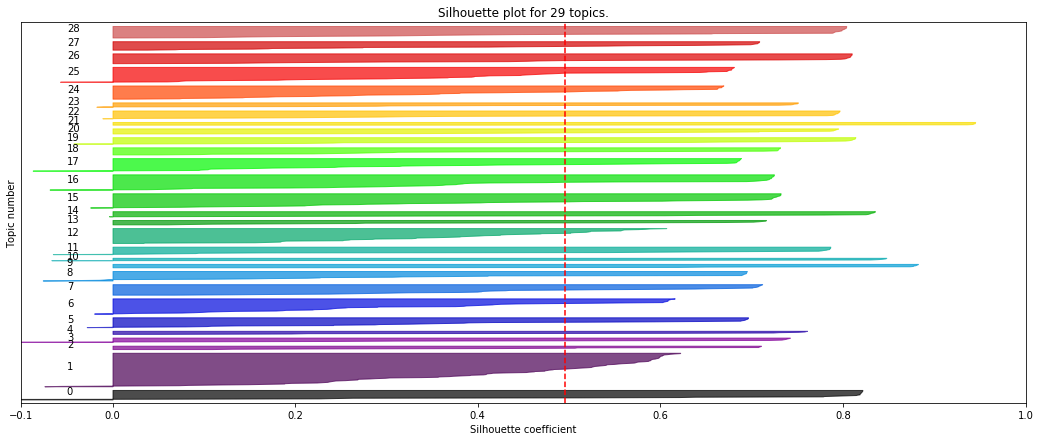

0: 0.041*"sera" + 0.029*"cuore" + 0.025*"frizzo" + 0.020*"letizia" + 0.017*"olga" + 0.015*"venezia" + 0.015*"ottavio" + 0.013*"settimana" + 0.013*"martedì" + 0.013*"salso" + 0.012*"sabato" + 0.012*"domenica" + 0.011*"abbracciare" + 0.011*"bepi" + 0.011*"mattina" + 0.010*"giovedì" + 0.009*"bagnare" + 0.009*"ritornare" + 0.009*"settembre" + 0.008*"livia"

1: 0.035*"romanzare" + 0.021*"professore" + 0.020*"studiare" + 0.020*"amicare" + 0.018*"pasini" + 0.017*"ricordare" + 0.015*"saba" + 0.014*"romanzo" + 0.013*"svevo" + 0.013*"succedere" + 0.012*"pagina" + 0.011*"pittore" + 0.011*"gratitudine" + 0.011*"nouvelle" + 0.011*"esimio" + 0.010*"regalare" + 0.010*"errore" + 0.010*"volume" + 0.010*"villa" + 0.009*"hotel"

2: 0.029*"fumare" + 0.026*"caffè" + 0.016*"sera" + 0.015*"dispaccio" + 0.014*"marcare" + 0.012*"bottone" + 0.011*"donna" + 0.011*"notizia" + 0.010*"notte" + 0.010*"trieste" + 0.010*"bontà" + 0.010*"restare" + 0.010*"fabbricare" + 0.010*"domenica" + 0.009*"bisognare" + 0.008*"mari

For 30 topic the average silhouette score is : 0.44817953301084634

Coherence: 0.34468896755675665



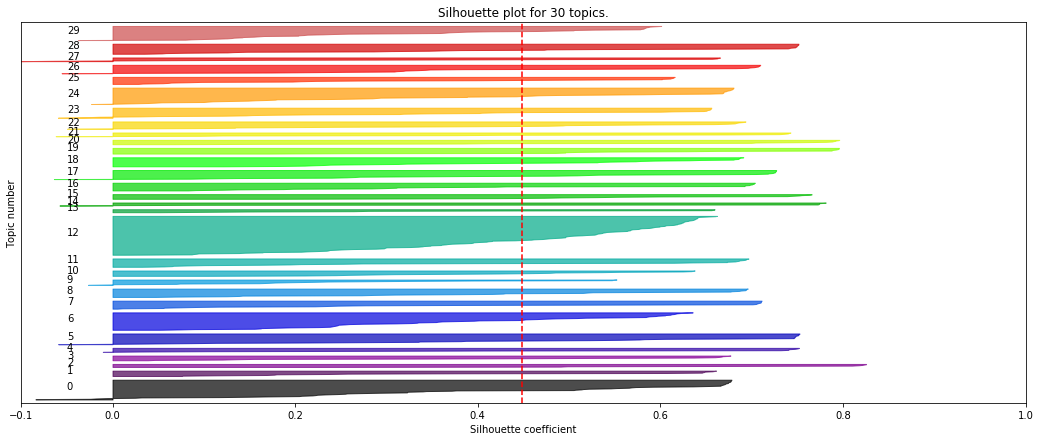

0: 0.017*"cuore" + 0.016*"sera" + 0.014*"olga" + 0.011*"salso" + 0.010*"figliuolo" + 0.010*"domenica" + 0.010*"baciare" + 0.010*"atto" + 0.010*"bepi" + 0.009*"pranzare" + 0.009*"abbracciare" + 0.009*"marcare" + 0.009*"venezia" + 0.008*"spesa" + 0.007*"assenza" + 0.007*"testare" + 0.007*"pensiero" + 0.007*"sacrificio" + 0.007*"mercoledì" + 0.007*"denaro"

1: 0.044*"senilità" + 0.037*"amicare" + 0.034*"librare" + 0.023*"articolare" + 0.021*"joyce" + 0.019*"larbaud" + 0.018*"maestro" + 0.016*"editore" + 0.015*"libro" + 0.015*"zeno" + 0.015*"piacere" + 0.015*"benco" + 0.013*"romanzare" + 0.012*"convegno" + 0.012*"scrivere" + 0.011*"piaggiare" + 0.011*"eugenio" + 0.011*"saluto" + 0.011*"firenze" + 0.011*"bobi"

2: 0.029*"uomini" + 0.024*"fabbricare" + 0.022*"coiazzi" + 0.021*"bravin" + 0.016*"tono" + 0.016*"vaso" + 0.015*"bambino" + 0.014*"edizione" + 0.014*"febbre" + 0.013*"addio" + 0.013*"notte" + 0.011*"occhio" + 0.011*"vento" + 0.010*"fuoco" + 0.010*"vecchio" + 0.010*"signorina" + 0.010

For 31 topic the average silhouette score is : 0.44850149584908056

Coherence: 0.3761183250422253



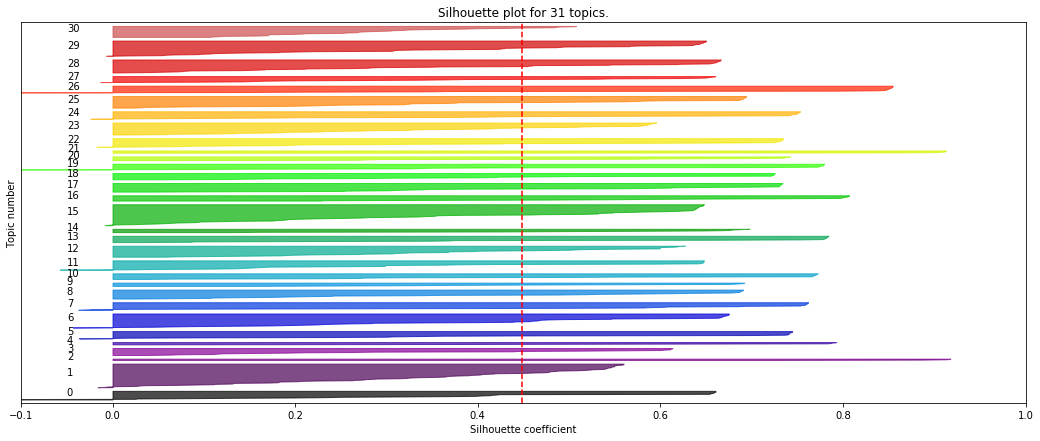

0: 0.049*"sera" + 0.029*"cuore" + 0.017*"martedì" + 0.016*"domenica" + 0.014*"trieste" + 0.014*"olga" + 0.014*"bepi" + 0.013*"settimana" + 0.012*"venezia" + 0.011*"fumare" + 0.011*"mattina" + 0.011*"giovedì" + 0.011*"sabato" + 0.010*"marcare" + 0.010*"leggere" + 0.009*"notizia" + 0.009*"pranzare" + 0.009*"ritornare" + 0.009*"giornata" + 0.008*"bestia"

1: 0.036*"amicare" + 0.034*"articolare" + 0.024*"joyce" + 0.021*"larbaud" + 0.021*"senilità" + 0.017*"saluto" + 0.015*"librare" + 0.014*"novello" + 0.014*"piaggiare" + 0.013*"parigi" + 0.013*"romanzare" + 0.012*"maestro" + 0.012*"fiero" + 0.012*"editore" + 0.012*"lettura" + 0.011*"eugenio" + 0.011*"mese" + 0.011*"aff" + 0.011*"amico" + 0.011*"criticare"

2: 0.028*"fondere" + 0.025*"curare" + 0.020*"marcare" + 0.013*"scrivere" + 0.012*"italiano" + 0.012*"puntare" + 0.011*"zeno" + 0.011*"trieste" + 0.011*"questione" + 0.011*"leggere" + 0.011*"sera" + 0.011*"cuore" + 0.011*"arte" + 0.010*"episodio" + 0.010*"bottone" + 0.010*"fabbricare" + 0

For 32 topic the average silhouette score is : 0.42324427681121524

Coherence: 0.36386268350908857



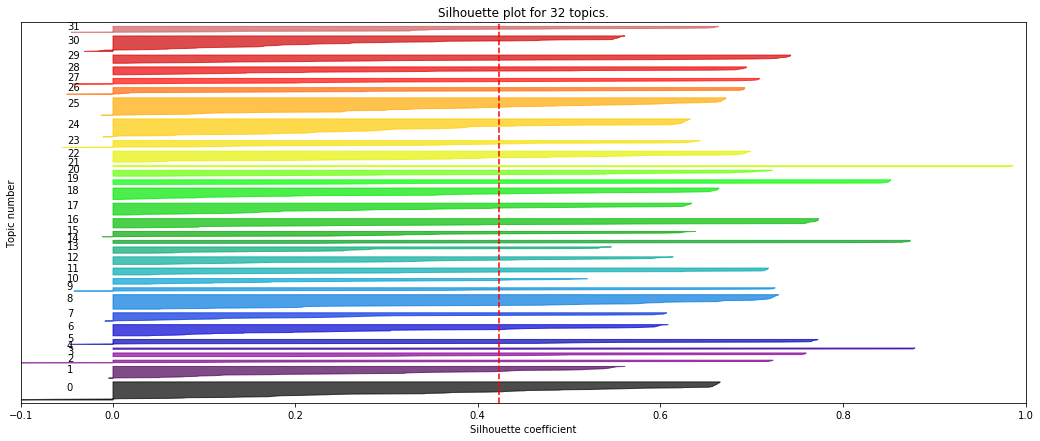

0: 0.029*"venezia" + 0.028*"sera" + 0.021*"cuore" + 0.017*"salso" + 0.016*"natalia" + 0.016*"letizia" + 0.013*"olga" + 0.013*"ragione" + 0.013*"stazione" + 0.011*"frizzo" + 0.011*"paola" + 0.011*"ottavio" + 0.011*"dirti" + 0.010*"pepe" + 0.010*"cenare" + 0.009*"baciare" + 0.008*"dimissione" + 0.008*"operare" + 0.007*"abbracciare" + 0.007*"pranzare"

1: 0.035*"curare" + 0.034*"lettura" + 0.026*"pubblicare" + 0.021*"freud" + 0.018*"romanzare" + 0.017*"succedere" + 0.017*"errore" + 0.016*"affettare" + 0.016*"senilità" + 0.015*"jahier" + 0.015*"zeno" + 0.014*"esperienza" + 0.013*"questione" + 0.012*"averle" + 0.010*"valerio" + 0.010*"letteratura" + 0.010*"conseguenza" + 0.010*"contare" + 0.010*"medicare" + 0.009*"spesare"

2: 0.028*"cuore" + 0.027*"denaro" + 0.026*"titina" + 0.024*"dirti" + 0.023*"sigaretta" + 0.022*"sera" + 0.016*"settimana" + 0.014*"baciare" + 0.014*"fumare" + 0.014*"gola" + 0.013*"restare" + 0.013*"riga" + 0.012*"pom" + 0.012*"venerdì" + 0.012*"viaggiare" + 0.011*"bagna

For 33 topic the average silhouette score is : 0.4502092678830775

Coherence: 0.37686400952839644



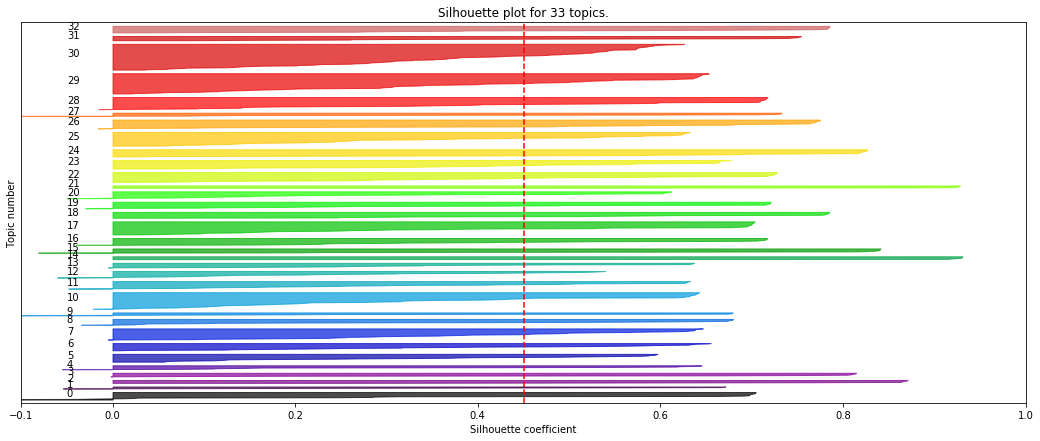

0: 0.032*"cuore" + 0.019*"notizia" + 0.017*"abbracciare" + 0.016*"sera" + 0.015*"bagnare" + 0.012*"mezzodì" + 0.012*"livia" + 0.012*"olga" + 0.012*"curare" + 0.012*"venezia" + 0.012*"trieste" + 0.011*"salsomaggiore" + 0.011*"sacrificio" + 0.011*"lira" + 0.010*"viaggiare" + 0.010*"ritornare" + 0.010*"leggere" + 0.010*"letizia" + 0.010*"pranzare" + 0.010*"baciare"

1: 0.029*"amicare" + 0.018*"joyce" + 0.017*"romanzare" + 0.017*"pubblicare" + 0.017*"convegno" + 0.016*"novello" + 0.016*"editore" + 0.015*"ricordare" + 0.015*"valore" + 0.015*"milano" + 0.014*"commerce" + 0.014*"critico" + 0.013*"studiare" + 0.012*"lettura" + 0.012*"rivisto" + 0.011*"saba" + 0.011*"senilità" + 0.010*"numerare" + 0.010*"riguardare" + 0.010*"comisso"

2: 0.041*"curare" + 0.026*"notte" + 0.021*"succedere" + 0.017*"sera" + 0.015*"dicembre" + 0.014*"riga" + 0.013*"fumare" + 0.012*"ventina" + 0.012*"freud" + 0.012*"solitudine" + 0.011*"compagnia" + 0.010*"dubbio" + 0.010*"averle" + 0.010*"dimmi" + 0.010*"italia" + 

For 34 topic the average silhouette score is : 0.43044963890488935

Coherence: 0.3879339317719545



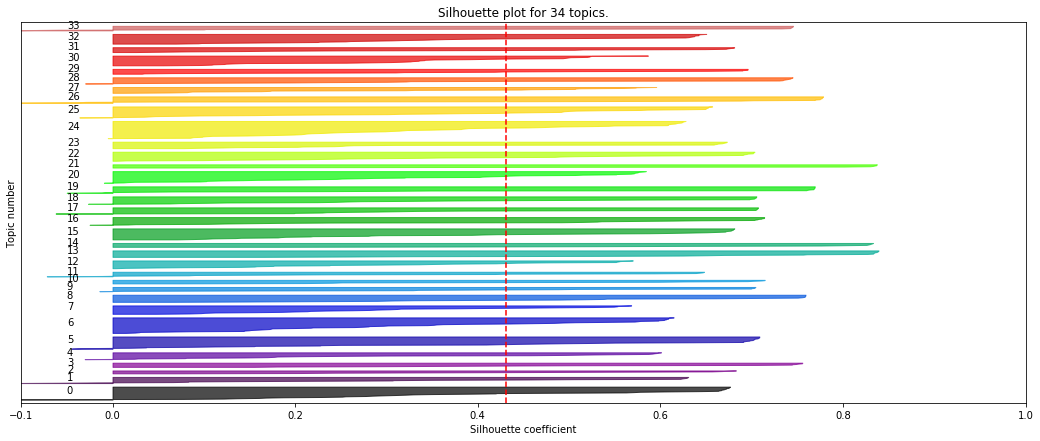

0: 0.024*"sera" + 0.020*"cuore" + 0.017*"sabato" + 0.015*"settimana" + 0.015*"marcare" + 0.013*"domenica" + 0.012*"bepi" + 0.011*"baciare" + 0.011*"olga" + 0.011*"trieste" + 0.010*"venezia" + 0.010*"dimissione" + 0.009*"pensione" + 0.009*"giovedì" + 0.008*"mercoledì" + 0.008*"viaggiare" + 0.007*"questione" + 0.007*"fondere" + 0.007*"lira" + 0.007*"figliuolo"

1: 0.022*"pubblicare" + 0.020*"amicare" + 0.019*"romanzare" + 0.017*"colorire" + 0.016*"studiare" + 0.014*"zeno" + 0.013*"storia" + 0.013*"letteratura" + 0.013*"importanza" + 0.012*"pagina" + 0.012*"articolare" + 0.012*"roba" + 0.011*"osservazione" + 0.011*"artista" + 0.011*"coscienza" + 0.011*"vino" + 0.010*"ricordare" + 0.010*"veruda" + 0.010*"regalare" + 0.009*"valore"

2: 0.022*"addio" + 0.021*"fabbricare" + 0.016*"puntare" + 0.016*"levico" + 0.015*"abbracciare" + 0.015*"curare" + 0.014*"restare" + 0.013*"lettura" + 0.012*"cuore" + 0.011*"pensiero" + 0.011*"olga" + 0.010*"salutare" + 0.010*"fondere" + 0.010*"umore" + 0.010*"do

For 35 topic the average silhouette score is : 0.48820302867155774

Coherence: 0.38090173202843164



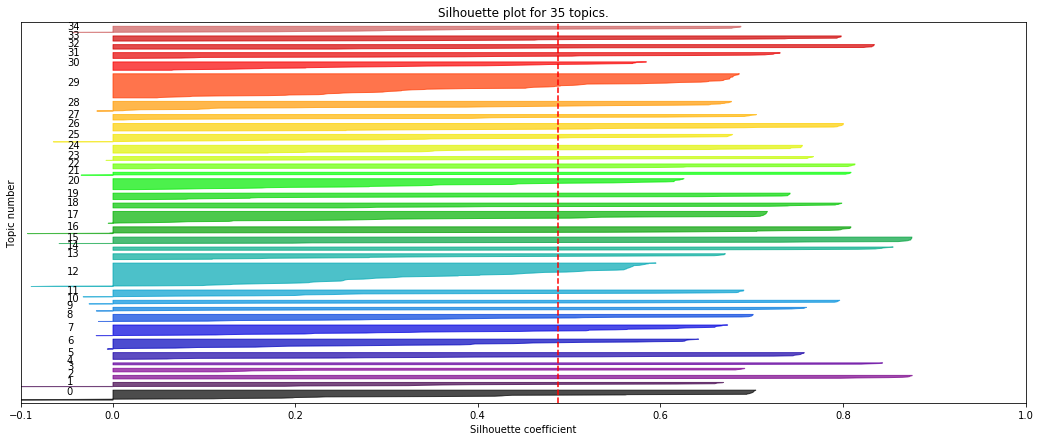

0: 0.020*"sera" + 0.017*"abbracciare" + 0.016*"cuore" + 0.016*"marcare" + 0.015*"venezia" + 0.014*"baciare" + 0.013*"notizia" + 0.012*"olga" + 0.010*"ritornare" + 0.010*"giovedì" + 0.010*"figliuolo" + 0.009*"sabato" + 0.009*"paola" + 0.008*"questione" + 0.008*"carne" + 0.008*"dimissione" + 0.007*"zencovich" + 0.007*"posto" + 0.007*"lira" + 0.007*"trieste"

1: 0.021*"colorire" + 0.016*"veruda" + 0.016*"errore" + 0.016*"ragione" + 0.015*"letizia" + 0.014*"studiare" + 0.013*"roba" + 0.013*"abbracciare" + 0.012*"cuore" + 0.012*"pubblicare" + 0.012*"pittore" + 0.011*"legnare" + 0.011*"osservazione" + 0.010*"testare" + 0.010*"piacere" + 0.009*"papà" + 0.009*"conseguenza" + 0.009*"basire" + 0.009*"capitolo" + 0.009*"fama"

2: 0.022*"fumare" + 0.022*"taglio" + 0.020*"caffè" + 0.019*"sera" + 0.016*"italiano" + 0.016*"donna" + 0.015*"leggere" + 0.015*"tavolo" + 0.015*"impiegare" + 0.013*"latta" + 0.013*"fondere" + 0.013*"zeno" + 0.012*"dispaccio" + 0.011*"curare" + 0.011*"camicia" + 0.011*"compa

For 36 topic the average silhouette score is : 0.501904785156813

Coherence: 0.3434504659634637



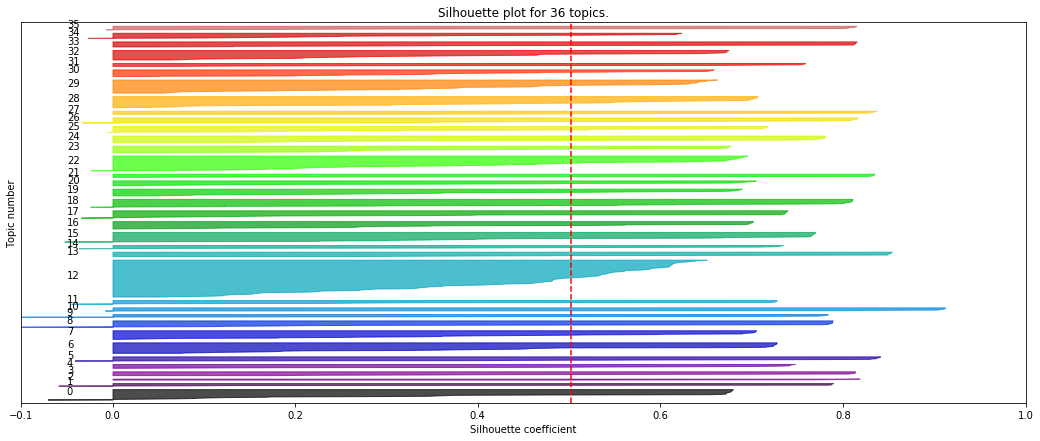

0: 0.019*"sera" + 0.014*"venezia" + 0.014*"baciare" + 0.013*"cuore" + 0.013*"salso" + 0.012*"dimissione" + 0.010*"maritare" + 0.010*"pom" + 0.009*"pepe" + 0.009*"sigaretta" + 0.008*"olga" + 0.008*"soldo" + 0.008*"figliuolo" + 0.008*"sangue" + 0.008*"bepi" + 0.008*"domenica" + 0.008*"campagna" + 0.007*"volere" + 0.007*"marcare" + 0.007*"pensiero"

1: 0.022*"dr" + 0.022*"piacere" + 0.020*"colorire" + 0.015*"trieste" + 0.015*"roba" + 0.015*"notizia" + 0.014*"lira" + 0.014*"editore" + 0.014*"famiglia" + 0.014*"legnare" + 0.013*"senilità" + 0.013*"letizia" + 0.012*"perdita" + 0.012*"farmi" + 0.012*"amicare" + 0.011*"gente" + 0.011*"circostanza" + 0.010*"bepi" + 0.010*"penna" + 0.010*"lunare"

2: 0.026*"curare" + 0.016*"notizia" + 0.016*"ottavio" + 0.016*"disordine" + 0.012*"specie" + 0.012*"taglio" + 0.012*"lettura" + 0.012*"frizzo" + 0.012*"padre" + 0.012*"dimmi" + 0.012*"esitazione" + 0.011*"italia" + 0.010*"testare" + 0.010*"leggere" + 0.009*"zeno" + 0.009*"critico" + 0.009*"bepi" + 0.00

For 37 topic the average silhouette score is : 0.5149283312427273

Coherence: 0.3426435402055285



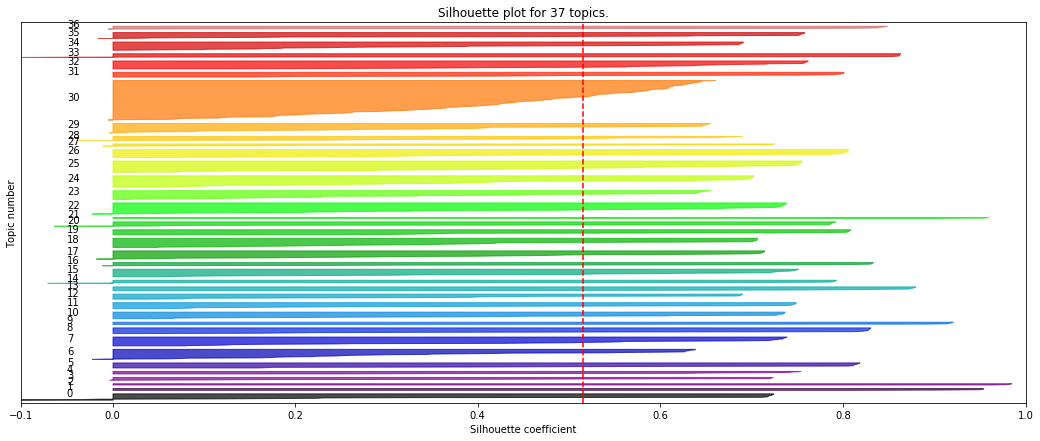

0: 0.017*"abbracciare" + 0.015*"olga" + 0.015*"ritornare" + 0.013*"ragione" + 0.011*"madre" + 0.011*"cuore" + 0.011*"venezia" + 0.010*"baciare" + 0.010*"questione" + 0.010*"partenza" + 0.010*"salso" + 0.010*"posto" + 0.009*"salsomaggiore" + 0.009*"periodare" + 0.009*"sacrificio" + 0.008*"vero" + 0.008*"figliuolo" + 0.008*"sera" + 0.007*"pittore" + 0.007*"buono"

1: 0.047*"senilità" + 0.044*"librare" + 0.042*"amicare" + 0.029*"zeno" + 0.023*"articolare" + 0.022*"editore" + 0.021*"maestro" + 0.019*"traduzione" + 0.019*"convegno" + 0.017*"romanzare" + 0.015*"bobi" + 0.014*"coscienza" + 0.014*"letteratura" + 0.013*"piacere" + 0.013*"larbaud" + 0.013*"milano" + 0.012*"critico" + 0.012*"eugenio" + 0.011*"mese" + 0.010*"parigi"

2: 0.025*"bottone" + 0.021*"titina" + 0.020*"scrivere" + 0.016*"curare" + 0.015*"baciare" + 0.013*"questione" + 0.013*"cuore" + 0.013*"sigaretta" + 0.012*"direttore" + 0.012*"comunicazione" + 0.012*"pesce" + 0.011*"pezzo" + 0.010*"abbracciare" + 0.010*"puntare" + 0.01

For 38 topic the average silhouette score is : 0.47577515033902756

Coherence: 0.36730329085620506



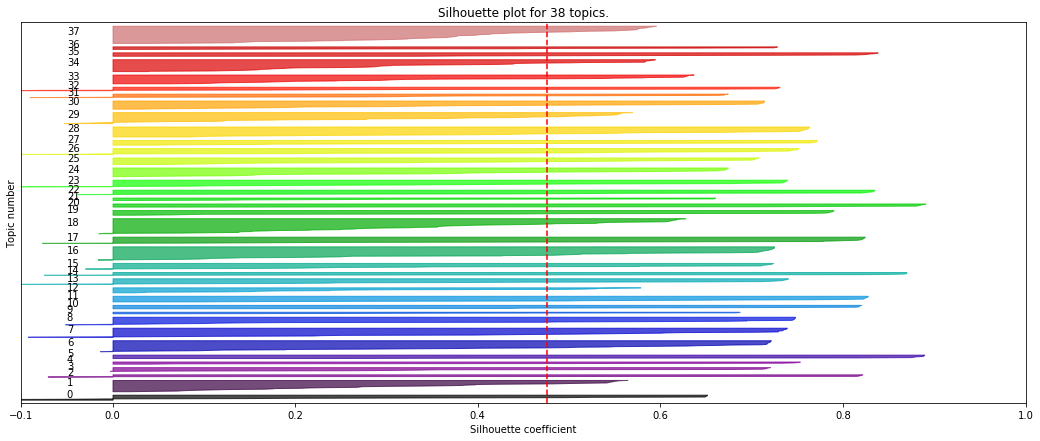

0: 0.047*"sera" + 0.039*"trieste" + 0.032*"cuore" + 0.021*"sabato" + 0.021*"abbracciare" + 0.020*"scheifling" + 0.019*"olga" + 0.019*"domenica" + 0.018*"baciare" + 0.016*"notizia" + 0.016*"freddare" + 0.015*"marcare" + 0.015*"settimana" + 0.014*"giovedì" + 0.013*"scrivere" + 0.012*"bepi" + 0.012*"martedì" + 0.011*"ritornare" + 0.011*"mattina" + 0.010*"partenza"

1: 0.027*"colorire" + 0.022*"letizia" + 0.020*"cuore" + 0.019*"legnare" + 0.018*"paura" + 0.014*"divertimento" + 0.013*"farti" + 0.013*"cenare" + 0.013*"piacere" + 0.012*"vino" + 0.011*"carne" + 0.011*"provare" + 0.011*"farmi" + 0.011*"sorto" + 0.011*"settimana" + 0.010*"dubbio" + 0.010*"mattina" + 0.010*"roba" + 0.009*"sacrificio" + 0.009*"punto"

2: 0.048*"fumare" + 0.025*"sera" + 0.025*"cuore" + 0.020*"italia" + 0.018*"angelo" + 0.016*"letizia" + 0.015*"qualità" + 0.013*"leggere" + 0.013*"marcare" + 0.012*"notizia" + 0.011*"maritare" + 0.011*"fatturare" + 0.011*"bagnare" + 0.011*"malumore" + 0.011*"banca" + 0.011*"dormire" +

For 39 topic the average silhouette score is : 0.4725920950093925

Coherence: 0.35257669384394863



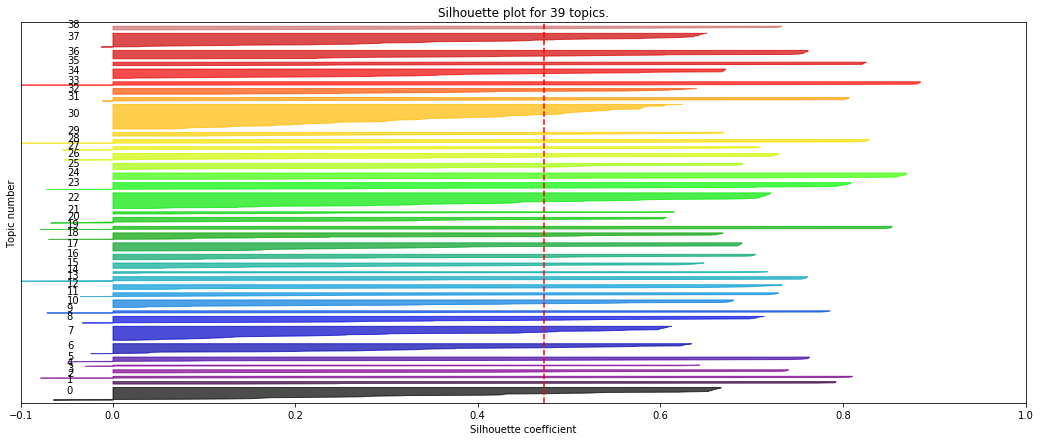

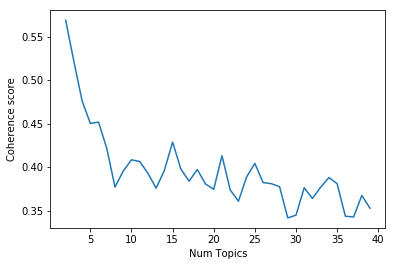

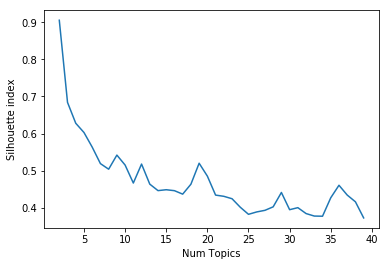

In [347]:
n_topics = 40
models_test = []
d_test = corpora.Dictionary(texts_it)
d_test.filter_extremes(no_below=5, no_above=0.5)
c_test = [d_test.doc2bow(text) for text in texts_it]

for n in range(2, n_topics):
    model_test = create_lda_model(d_test, c_test, n, passes = 200)
    assess_model_goodness(model_test, texts_it, c_test, d_test, n)
    models_test.append(model_test)

silhouette_list = [compute_silhouette(model_test, c_test, len(model_test.print_topics())) for model_test in models_test]
perplexity_list = [compute_perplexity(model_test, c_test) for model_test in models_test]
coh_v = [compute_coherence(model_test, texts_it, c_test, d_test, coherence = "c_v") for model_test in models_test]

x = range(2,n_topics)
plt.plot(x, coh_v)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.show()
plt.plot(x, silhouette_list)
plt.xlabel("Num Topics")
plt.ylabel("Silhouette index")
plt.show()

# Extra: Similarity inside topics using Word2Vec italian embeddings

We used the embedding produced by the Italian NLP Lab, available [here](http://www.italianlp.it/resources/italian-word-embeddings/).
To use this, simply download the itwac128.txt file and put it inside the datasets folder.

First step is filtering out words containing alpha characters, since they break the gensim W2V algorithm.

In [283]:
from tqdm import tqdm

# Repeated from above
data_it = data[data.mainLanguage == "ITA"]
texts_it = [preprocess_text(text, nlp_it, stop_words=stop_words, pos = ['PROPN', 'NOUN']) for text in data_it["text"]]
d_it = corpora.Dictionary(texts_it)
d_it.filter_extremes(no_below=5, no_above=0.5)
c_it = [d_it.doc2bow(text) for text in texts_it]

file_r = open("datasets/itwac128.txt", "r")
file_w = open("datasets/we_it.txt", "w")
for line in tqdm(file_r):
    line_vec = line.split("\t")
    if(str(line_vec[0]).isalpha()):
        file_w.write(" ".join(line_vec))
print(sum(1 for _ in file_w))

1247492it [00:21, 56988.41it/s]


We try out the italian semantic vector we just created

In [ ]:
vectors = KeyedVectors.load_word2vec_format('we_it.txt', binary = False)
vectors.most_similar(positive=['gatto', 'topo'], topn=10)

Finally, we show the vocabulary of our letter corpus in 2D, matching words to their W2V vectors projected on principal components.
We highlight in different colors the words that belong to the different topics we found.

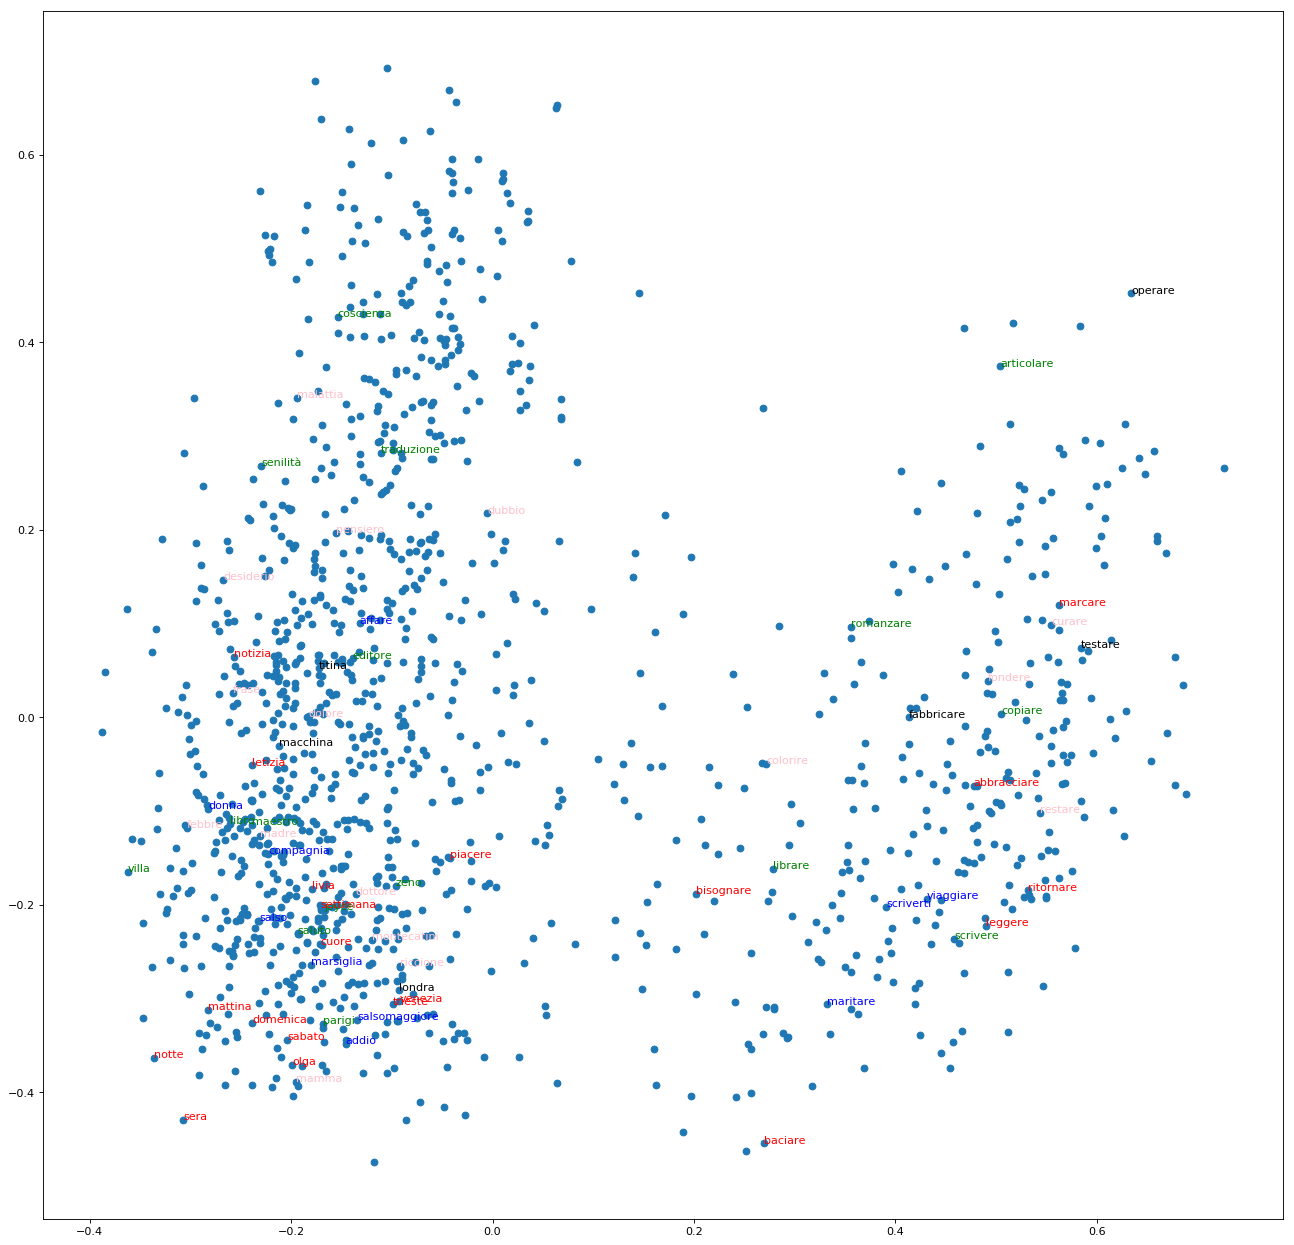

In [485]:
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from matplotlib import pyplot
from matplotlib.pyplot import figure

# Create an LDA model with 5 topics.
lda_model = create_lda_model(d_it, c_it, 5, passes = 200)

# Extract sentences from our dataframe.
sentences = [[d_it[id] for id, freq in cp] for cp in c_it]

# Build Word2Vec model from corpus sentences.
w2v_model = Word2Vec(sentences, min_count=1)

# Filter corpus vocabulary based on W2V lexicon.
f_vocab = {k:v for k,v in model.wv.vocab.items() if k in vectors.wv.vocab}

# Transform W2V vectors on 2D vectors based on principal components.
X = vectors[f_vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)

# Show vectors in space
figure(num=None, figsize=(20, 20), dpi=80, facecolor='w', edgecolor='k')
pyplot.scatter(result[:, 0], result[:, 1])
words = list(f_vocab)
keywords = get_lda_keywords(lda_model)
for i, word in enumerate(words):
    if word in keywords[0]:
        pyplot.annotate(word, xy=(result[i, 0], result[i, 1]), color = "red") # family
    elif word in keywords[1]:
        pyplot.annotate(word, xy=(result[i, 0], result[i, 1]), color = "green") # literature
    elif word in keywords[2]:
        pyplot.annotate(word, xy=(result[i, 0], result[i, 1]), color = "black") # work
    elif word in keywords[3]:
        pyplot.annotate(word, xy=(result[i, 0], result[i, 1]), color = "blue") # travel
    elif word in keywords[4]:
        pyplot.annotate(word, xy=(result[i, 0], result[i, 1]), color = "pink") # health
    #else:
    #    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()